In [1]:
# TODO
# Create function to get all edge IDs for a given Adm2 Unit

# Create function to extract deforestation data for edge
# - Add weighting option (distance-based from river)
# - Add river width-based weighting option
# - Allow choice between simple buffer and slope-based buffer

# Network model

In [1]:
import pickle
import sqlite3
import shapely
from shapely.geometry import Point, MultiPoint
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
from multiprocessing import Pool
from collections import defaultdict
import xarray as xr
import rioxarray as rxr
import os
from pysheds.grid import Grid
from rasterio.io import MemoryFile
import cv2

# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

i = 525

rivers = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/msc_rivers.feather").to_crs(5641)
rivers_subset = gpd.clip(rivers, grid_data.geometry.iloc[i])

boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine = "pyogrio").to_crs(5641)
boundaries_subset = gpd.clip(boundaries, grid_data.geometry.iloc[i])

---

In [2]:
def add_intersections_chunk(chunk_data):
    """
    This function add vertices to a chunk of river geometries at the intersections with boundaries.
    It is designed to be used with Pool.map() to process data in parallel.
    
    Parameters
    ----------
    chunk_data : tuple
        A tuple containing a GeoDataFrame of river geometries and a GeoSeries of boundaries.
    
    Returns
    -------
    oshapefile : GeoDataFrame
        A GeoDataFrame containing the river geometries with added vertices.
    ointersections : list
        A list of tuples containing the coordinates of the added vertices.
    """
    chunk, cboundaries_line, cboundaries_polygon = chunk_data
    chunk["intersecting_boundary_ids"] = pd.NA
    ointersections = [None] * len(chunk)
    # get intersections with boundaries
    #cintersections = chunk.intersection(cboundaries)
    # iterate over chunk
    for j in range(len(chunk)):
        # get intersections with boundaries for current geometry
        ccintersections_boundary = gpd.GeoSeries(shapely.intersection(chunk.iloc[j].geometry, cboundaries_line)[0])#cintersections.iloc[j]
        ccintersections_full = gpd.GeoSeries(shapely.intersection(chunk.iloc[j].geometry, cboundaries_polygon)["geometry"])
        # if there are intersections
        if not all(ccintersections_full.is_empty):
            # write all intersecting boundary ids to shapefile
            chunk.at[chunk.index[j], "intersecting_boundary_ids"] = ccintersections_full[~ccintersections_full.is_empty].index.values
        if not all(ccintersections_boundary.is_empty):
            cintersections = []
            # extract points from MultiPoint geometries
            for i in range(len(ccintersections_boundary[~ccintersections_boundary.is_empty])):
                if ccintersections_boundary[~ccintersections_boundary.is_empty].iloc[i].geom_type == "MultiPoint":
                    cintersections += [list(ccintersections_boundary[~ccintersections_boundary.is_empty].iloc[i].geoms)]
                if ccintersections_boundary[~ccintersections_boundary.is_empty].iloc[i].geom_type == "Point":
                    cintersections += [[ccintersections_boundary[~ccintersections_boundary.is_empty].iloc[i]]]
            # create a GeoDataFrame of line points and intersections
            cvertice_points = pd.concat([
                gpd.GeoDataFrame(dict(geometry = [Point(x) for x in chunk.iloc[j].geometry.coords], type = "internal")),
                gpd.GeoDataFrame(dict(geometry = np.concatenate(cintersections), type = "external"))
            ], ignore_index = True)
            ## sort points by distance along line
            # add distance along line to points
            # credit: https://gis.stackexchange.com/a/413748
            cvertice_points['dist_along_line'] = cvertice_points['geometry'].apply(lambda p: chunk.iloc[j].geometry.project(p))
            # sort points by distance along line
            cvertice_points = cvertice_points.sort_values(by='dist_along_line')
            # write back to shapefile
            chunk.loc[chunk.index[j],"geometry"] = shapely.geometry.LineString(cvertice_points['geometry'].values)
            # store border_nodes
            ointersections[j] = [x.coords[0] for x in np.concatenate(cintersections)]
    if not all([x is None for x in ointersections]):
        ointersections = np.concatenate([x for x in ointersections if x is not None])
    else:
        ointersections = []
    return chunk, ointersections

def split_vertice(split_data):
    """
    This function splits a river geometry at the nodes provided.
    It is designed to be used with Pool.map() to process data in parallel.

    Parameters
    ----------
    split_data : tuple
        A tuple containing a GeoSeries of river geometries and a numpy array of indices of nodes to split at.

    Returns
    -------
    cvertice : GeoSeries
        A GeoSeries containing the river geometry with added vertices.
    """
    cvertice, csplit_ids = split_data
    while csplit_ids.size != 0:
        # get node to split at
        if type(cvertice.geometry) == shapely.geometry.linestring.LineString:
            # get coordinates of river
            ccoords = np.array(cvertice.geometry.coords)
            # pop node to split at
            isplit = csplit_ids[0]
            csplit_ids = csplit_ids[1:]
            # split river geometry
            cvertice["geometry"] = shapely.geometry.MultiLineString([shapely.geometry.LineString(ccoords[:isplit+1]), shapely.geometry.LineString(ccoords[(isplit):])])
            # fix indices
            csplit_ids[csplit_ids > isplit] += 1
        elif type(cvertice.geometry) == shapely.geometry.multilinestring.MultiLineString:
            # get coordinates of sub-LineStrings in river
            ccoords = np.concatenate([x.coords for x in cvertice.geometry.geoms])
            # get index of sub-LineString at coord
            csubindex = np.repeat(np.arange(len(cvertice.geometry.geoms)), [len(x.coords) for x in cvertice.geometry.geoms])
            # pop node to split at
            isplit = csplit_ids[0]
            csplit_ids = csplit_ids[1:]
            # fix indices
            csplit_ids[csplit_ids > isplit] += 1
            # get index of sub-LineString to split
            iisplit = csubindex[isplit]
            # get index of node in sub-LineString
            isplit -= np.sum([len(x.coords) for x in list(cvertice.geometry.geoms)[:iisplit]])
            # skip if node is at end of sub-LineString
            if (isplit == 0 or isplit == len(ccoords[csubindex==iisplit]) - 1):
                continue
            # split river geometry
            ccoords = list(cvertice.geometry.geoms)[:iisplit] + [shapely.geometry.LineString(ccoords[csubindex==iisplit][:isplit+1])] +\
                [shapely.geometry.LineString(ccoords[csubindex==iisplit][isplit:])] + list(cvertice.geometry.geoms)[iisplit+1:]
            cvertice["geometry"] = shapely.geometry.MultiLineString([shapely.geometry.LineString(x) for x in ccoords])
    return cvertice

class river_network:
    """
    A class representing a river network.
    """
    def __init__(self, shapefile, boundaries, coastline):
        self.shapefile = shapefile
        self.boundaries = boundaries
        self.coastline = coastline
        self.edges_fl = None
        self.points = None
        self.points_indices = None
        self.network_nodes = None
        self.border_nodes = None
        self.end_nodes = None
        self.nodes = None
        self.nodes_types = None
                
    def explode_rivers(self):
        self.shapefile = self.shapefile.explode(index_parts=True)
        #self.shapefile.index = self.shapefile.index.map(lambda x: x[0] * 100 + x[1])
        
    def update_vertices(self):
        print("*** Updating vertices ***")
        # get vertices as numpy array of line coordinates
        vertices = self.shapefile.geometry.map(lambda x: np.array(x.coords))
        # get first and last vertex of each line
        self.edges_fl = self.shapefile.geometry.map(lambda x: np.array(x.coords)[[0,-1]])
        # get indices of flat list of vertices
        self.points_indices = np.repeat(vertices.index, vertices.map(len))
        # flatten vertices
        self.points = np.vstack(vertices)
        
    def update_nodes(self):
        self.nodes = np.concatenate([self.network_nodes, self.border_nodes, self.end_nodes])
        self.nodes_types = np.concatenate([np.repeat("network", len(self.network_nodes)), np.repeat("border", len(self.border_nodes)), np.repeat("end", len(self.end_nodes))])
        
    def update_network_nodes(self):
        print("*** Updating network nodes ***")
        # get unique points and their counts
        points_counts = np.unique(self.points, return_counts = True, axis = 0)
        # get network nodes (points with more than one occurrence)
        network_nodes = points_counts[0][points_counts[1] > 1]
        # combine nodes and create type array
        self.network_nodes = network_nodes
        
    def update_border_nodes(self):
        print("*** Updating border nodes ***")
        ## split up the shapes into smaller chunks of 10000 geometries
        #   (any speed up here requires the order of geometries in the shapefile to correspond to proximity in space
        #   hence we cluster the geometries to obtain cluster with spatial proximity)
        # extract representative points
        representative_points = self.shapefile.centroid
        coords = np.array(list(zip(representative_points.x, representative_points.y)))
        # perform spatial clustering
        mbkmeans = MiniBatchKMeans(n_clusters=((self.shapefile.shape[0] // 1000) + 1), batch_size=10000, random_state=42)
        cluster_labels = mbkmeans.fit_predict(coords)
        # split the shapefile into chunks
        chunks = [self.shapefile[cluster_labels == i].copy() for i in range(mbkmeans.n_clusters)]

        # a function to expand bounds by a factor
        def expand_bounds(bounds, factor = 1.1):
            return [bounds[0] - (bounds[2] - bounds[0]) * (factor - 1) / 2, bounds[1] - (bounds[3] - bounds[1]) * (factor - 1) / 2, bounds[2] + (bounds[2] - bounds[0]) * (factor - 1) / 2, bounds[3] + (bounds[3] - bounds[1]) * (factor - 1) / 2]
        
        # prepare data for multiprocessing
        data_for_processing = []
        #dissolved_shapefile = self.boundaries.dissolve().boundary#.geometry.iloc[0]
        for chunk in chunks:
            cbounds = expand_bounds(chunk.total_bounds)
            cboundaries_line = gpd.clip(self.boundaries.boundary, cbounds).to_frame()
            cboundaries_polygon = gpd.clip(self.boundaries.geometry, cbounds).to_frame()
            if cboundaries_line.empty:
                continue
            #cboundaries = cboundaries.dissolve().geometry.iloc[0]
            data_for_processing.append((chunk.copy(), cboundaries_line, cboundaries_polygon))

        # use Pool to process data in parallel
        #results = [add_intersections_chunk(data_for_processing[i]) for i in range(8)]
        with Pool(4) as pool:
            results = list(tqdm(pool.imap(add_intersections_chunk, data_for_processing), total=len(data_for_processing), unit="chunk"))
        
        # Post-process results
        # Replace geometries with added vertices
        self.shapefile["intersecting_boundary_ids"] = pd.NA
        self.shapefile.update(pd.concat([x[0] for x in results]))
        # Flatten list of intersections and update `self.border_nodes`
        self.border_nodes = np.concatenate([x[1] for x in results if not x[1] == []])

    def update_end_nodes(self):
        # Note: All estuary nodes are also end nodes
        print("*** Updating end nodes ***")
        # get unique points and their counts
        points_counts = np.unique(self.points, return_counts = True, axis = 0)
        # get those that only appear once
        points_ends = points_counts[0][points_counts[1] == 1]
        ## Get indices of single occurrence points as end candidates
        # Convert arrays to lists of tuples
        points_ends_hashed = [tuple(row) for row in points_ends]
        points_hashed = [tuple(row) for row in self.points]
        # Create a dictionary from elements of the points array to their indices
        dict_points = {elem: i for i, elem in enumerate(points_hashed)}
        # Find matching indices
        points_ends_indices = np.array([dict_points.get(elem, None) for elem in points_ends_hashed])
        ## Get end candidates that are at end of their respective line
        points_ends_reshaped = self.points[points_ends_indices][:, np.newaxis, :]
        edges_fl_subset = np.stack(self.edges_fl.loc[self.points_indices[points_ends_indices]])
        node_external_boolean = np.any(np.all(points_ends_reshaped == edges_fl_subset, axis=2), axis=1)
        # get ends (points with exactly one occurrence at end of line)
        self.end_nodes = self.points[points_ends_indices[node_external_boolean]]
        
    def update_estuary_nodes(self):
        # turn coastline into dictionary for faster lookup
        coastline_dict = {tuple(x): i for i, x in enumerate(np.array(self.coastline.iloc[0].geometry.coords))}
        # get indices of points that are at coastline
        points_coastline_indices = np.array([coastline_dict.get(tuple(x), np.nan) for x in self.points])
        # get estuary nodes
        self.estuary_nodes = self.points[np.logical_not(np.isnan(points_coastline_indices))]
        
    def break_lines_at_nodes(self):
        print("*** Breaking lines at nodes ***")
        ## get indices of points that are nodes
        # create a dictionary from elements of the points array to their indices
        dict_points = defaultdict(list)
        # Iterate over pairs of corresponding tuples from both arrays
        for point, index in zip(self.points, self.points_indices):
            # Convert numpy arrays to tuples for hashing
            point_tuple = tuple(point)
            # Append the index to the list corresponding to the point
            dict_points[point_tuple].append(index)
        # Convert defaultdict to dict if necessary
        mapping_dict = dict(dict_points)
        
        # get indices of nodes with node
        vertices_w_nodes_indices = np.vstack([dict_points.get(elem, np.nan) for elem in [tuple(row) for row in self.nodes]])
        # get unique indices
        vertices_w_nodes_indices = np.unique(vertices_w_nodes_indices, axis = 0)
        # create dictionary from elements of the nodes array to True
        dict_nodes = {tuple(x): True for x in self.nodes}
        
        data_for_processing = []
        for vertice_id in vertices_w_nodes_indices:
            # get the current vertice
            cvertice = self.shapefile.loc[tuple(vertice_id)]
            #
            if type(cvertice.geometry) == shapely.geometry.linestring.LineString:
                cvertice_coordinates = cvertice.geometry.coords
            elif type(cvertice.geometry) == shapely.geometry.linestring.MultiLineString:
                cvertice_coordinates = np.concatenate([x.coords for x in cvertice.geometry.geoms])
            # get the indices of the points that are nodes
            csplit_ids = np.where([dict_nodes.get(x, 0) for x in cvertice_coordinates])[0]
            csplit_ids = csplit_ids[((csplit_ids!=0) &(csplit_ids!=(len(cvertice_coordinates)-1)))]
            # if there are nodes to split at, add to data for processing
            if (not csplit_ids.size == 0):
                data_for_processing.append((cvertice.copy(), csplit_ids))
    
        # use Pool to process data in parallel
        with Pool(4) as pool:
            results = list(tqdm(pool.imap(split_vertice, data_for_processing), total=len(data_for_processing), unit="vertices"))
        #results = [split_vertice(x) for x in data_for_processing[:1000]]
        
        # Replace geometries with added vertices
        self.shapefile.update(pd.DataFrame().from_records(results, index = [x.name for x in results])) 
                
    def clean_shapefile(self):
        # a dict from end point to river end id(s)
        rivers_ends = self.shapefile.copy().geometry.map(lambda x: tuple(np.array(x.coords)[-1]))
        rivers_ends = rivers_ends.reset_index()
        rivers_ends["index"] = rivers_ends[["level_0", "level_1", "level_2"]].apply(tuple, axis = 1)
        rivers_ends_dict = rivers_ends.groupby(rivers_ends["geometry"]).index.apply(list).to_dict()
        # a dict from river id to start point
        rivers_starts = self.shapefile.geometry.map(lambda x: tuple(np.array(x.coords)[0]))
        rivers_starts_dict = dict(zip(rivers_starts.index, rivers_starts))
        # a dict to check if a point is a river source node
        end_nodes_dict = dict(zip([tuple(x) for x in self.end_nodes], range(len(self.end_nodes))))
        # a dict to check if a point is a river network node
        network_nodes_dict = dict(zip([tuple(x) for x in self.network_nodes], range(len(self.network_nodes))))
        # a dict to check if a point is a river border node
        border_nodes_dict = dict(zip([tuple(x) for x in self.border_nodes], range(len(self.border_nodes))))
        # a dict to check if a point is a river estuary node
        coastline_dict = {tuple(x): i for i, x in enumerate(np.array(self.coastline.iloc[0].geometry.coords))}
        
        # prepare a database for nodes
        self.shapefile[["downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment"]] = np.nan
        self.topology = gpd.GeoDataFrame(index = range(len(self.nodes)), columns = ["estuary", "confluence", "source", "border", "geometry"])
        self.topology["estuary"] = np.logical_not(np.isnan(np.array([coastline_dict.get(tuple(x), np.nan) for x in self.nodes])))  # get indices of points that are at coastline
        self.topology["confluence"] = self.nodes_types == "network"
        self.topology["source"] = ((self.nodes_types == "end") & ~(self.nodes_types == "estuary"))
        self.topology["border"] = self.nodes_types == "border"
        self.topology["geometry"] = [Point(x) for x in self.nodes]
        
        # function to parse river
        def worker(edge_id, downstream_node_id, estuary, river, segment, subsegment):
            # get end point of current node
            cend_node = rivers_starts_dict.get(edge_id, [])
            # get adm2 with largest intersection
            if not self.shapefile.loc[edge_id].isna().intersecting_boundary_ids:
                if self.shapefile.loc[edge_id].intersecting_boundary_ids.size > 1:
                    cadm_2 = self.shapefile.loc[edge_id].intersecting_boundary_ids[np.argmax(shapely.intersection(self.shapefile.loc[edge_id].geometry, boundaries.loc[self.shapefile.loc[edge_id].intersecting_boundary_ids].geometry).length)]
                else:
                    cadm_2 = self.shapefile.loc[edge_id].intersecting_boundary_ids
            else:
                cadm_2 = np.nan
            # update topology
            cis_border_node = border_nodes_dict.get(cend_node, None)
            cis_network_node = network_nodes_dict.get(cend_node, None)
            cis_end_node = end_nodes_dict.get(cend_node, None)
            # if end point is a network node
            if cis_network_node is not None:
                cnodeid = cis_network_node
                self.shapefile.loc[edge_id, ["downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment"]] = downstream_node_id, cnodeid, cadm_2, estuary, river, segment, subsegment
                # get all upstream river ids
                cnext_ids = rivers_ends_dict.get(cend_node, [])
                if len(cnext_ids) == 1:
                    # get next river id
                    cnext_id = cnext_ids[0]
                    # recursively update all upstream arms
                    estuary, river, segment, subsegment = worker(cnext_id, cnodeid, estuary, river, segment, subsegment + 1)
                else:
                    # check if there are rivers with the same name
                    same_name = [((self.shapefile.loc[cnext_id].NORIOCOMP == self.shapefile.loc[edge_id].NORIOCOMP) and (self.shapefile.loc[cnext_id].NORIOCOMP is not None)) for cnext_id in cnext_ids]
                    # get first river with same name
                    # Find the index of the first True value
                    if any(same_name):
                        start_index = same_name.index(True)
                    else:
                        start_index = 0
                    # Loop over items starting from the first True item, wrapping around as needed
                    for i in range(len(cnext_ids)):
                        # Calculate the current index, wrapping around using modulo
                        current_index = (start_index + i) % len(cnext_ids)
                        # if we are at the start index, maintain river id
                        if current_index == start_index:
                            estuary, river, segment, subsegment = worker(cnext_ids[current_index], cnodeid, estuary, river, segment + 1, 0)
                        # else increase river id
                        else:
                            estuary, river, segment, subsegment = worker(cnext_ids[current_index], cnodeid, estuary, river + 1, 0, 0)
            # if end point is a border node
            elif cis_border_node is not None:
                cnodeid = len(self.network_nodes) + cis_border_node
                self.shapefile.loc[edge_id, ["downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment"]] = downstream_node_id, cnodeid, cadm_2, estuary, river, segment, subsegment
                # get next river id
                cnext_id = rivers_ends_dict.get(cend_node, [])[0]
                # recursively update all upstream arms
                estuary, river, segment, subsegment = worker(cnext_id, cnodeid, estuary, river, segment + 1, 0)
            # if end point is a end node, return
            elif cis_end_node is not None:
                cnodeid = len(self.network_nodes) + len(self.border_nodes) + cis_end_node
                self.shapefile.loc[edge_id, ["downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment"]] = downstream_node_id, cnodeid, cadm_2, estuary, river, segment, subsegment
            return estuary, river, segment, subsegment
        
        # iterate over estuary nodes
        for i in tqdm(range(len(self.estuary_nodes))):#
            init_vertice = rivers_ends_dict.get(tuple(self.estuary_nodes[i]), [])[0]
            worker(init_vertice, np.nan, i, 0, 0, 0)
                
    def store_network(self, path):
        self.shapefile[["NORIOCOMP", "CORIO", "downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment", "geometry"]].to_feather(path + "shapefile.feather")
        self.topology.to_feather(path + "topology.feather")
        with open(path + "network.pkl", "wb") as f:
            pickle.dump(self, f)

In [53]:
rivers_brazil = river_network(rivers[(rivers.NORIOCOMP != "Linha de Costa")],
                              boundaries,
                              rivers[(rivers.NORIOCOMP == "Linha de Costa")])
# explode multi-geometries
rivers_brazil.explode_rivers()
rivers_brazil.update_vertices()
# compute nodes
rivers_brazil.update_network_nodes()
rivers_brazil.update_border_nodes() # (multiprocessing-enabled: est. 4min)
rivers_brazil.update_end_nodes()
rivers_brazil.update_vertices()
rivers_brazil.update_nodes()

# break lines at nodes
rivers_brazil.break_lines_at_nodes() # (multiprocessing-enabled: est. 10min)
rivers_brazil.explode_rivers()
rivers_brazil.update_vertices()
# clean shapefile
rivers_brazil.update_estuary_nodes()
rivers_brazil.clean_shapefile()
rivers_brazil.store_network("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/")

*** Updating vertices ***
*** Updating network nodes ***
*** Updating border nodes ***


100%|██████████| 138/138 [08:22<00:00,  3.64s/chunk]
/scratch/slurm_tmpdir/job_23279288/ipykernel_235531/881574475.py:197: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  self.border_nodes = np.concatenate([x[1] for x in results if not x[1] == []])


*** Updating end nodes ***
*** Updating vertices ***


---

In [3]:
rivers_brazil = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/network.pkl", "rb"))
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
rivers_brazil_topology = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/topology.feather")

---

In [4]:
# create a dict from end point to upstream river ids
dict_points = defaultdict(list)
# Iterate over pairs of corresponding tuples from both arrays
for point, index in zip(rivers_brazil_shapefile.dropna(subset = "downstream_node_id").downstream_node_id.astype(np.int32), rivers_brazil_shapefile.dropna(subset = "downstream_node_id").index):
    # Append the index to the list corresponding to the point
    dict_points[point].append(index)
# Convert defaultdict to dict
downstream_lookup = dict(dict_points)
# create a dict from river id to end node
upstream_lookup = {key: value for key, value in zip(rivers_brazil_shapefile.dropna(subset = "upstream_node_id").index, rivers_brazil_shapefile.dropna(subset = "upstream_node_id").upstream_node_id.astype(np.int32))}
# create a dict from river id to length
length_lookup = {key: value for key, value in zip(rivers_brazil_shapefile.dropna(subset = "upstream_node_id").index, rivers_brazil_shapefile.dropna(subset = "upstream_node_id").length)}
# create a dict to check if a point is a river source node
end_node_lookup = {x: True for x in rivers_brazil_topology[rivers_brazil_topology.source & ~rivers_brazil_topology.estuary].index}

In [5]:
# get all river ids of nodes at estuaries
estuary_ids = rivers_brazil_shapefile.query("river==0 & segment==0 & subsegment==0").index.to_list()

# prepare data for multiprocessing
datasets = []
for i in range(len(estuary_ids)):
    datasets.append([{key: 0 for key in rivers_brazil_shapefile[rivers_brazil_shapefile.estuary == rivers_brazil_shapefile.loc[estuary_ids[i]].estuary].dropna(subset = "upstream_node_id").index}, (estuary_ids[i], 0)])

# function to calculate segment offsets
def calculate_segment_offsets(dataset):
    query = [dataset[1]]
    out = dataset[0]
    while query:
        tmp = query.pop()
        out[tmp[0]] = tmp[1]
        if not end_node_lookup.get(upstream_lookup[tmp[0]], False):
            query += [(x, ((tmp[1] + length_lookup[tmp[0]]) % 100)) for x in downstream_lookup.get(upstream_lookup[tmp[0]], [])]
    return out
# compute segment offsets
segment_offsets = [calculate_segment_offsets(x) for x in datasets]

In [6]:
# write segment offsets to shapefile
rivers_brazil_shapefile["segment_offset"] = pd.NA
rivers_brazil_shapefile.update(pd.concat([pd.DataFrame({"segment_offset": x}) for x in segment_offsets]))

In [ ]:
# TODO: write distance from estuary

---

In [7]:
# create shapely polygons on a grid, spanning the entire planet with a resolution of 1 degrees
grid = gpd.GeoDataFrame(geometry = [shapely.geometry.box(i, j, i+1, j+1) for i in range(-180, 180, 1) for j in range(-90, 90, 1)])
grid["in_bbox"] = grid.intersects(shapely.geometry.box(*gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio").total_bounds))
grid["in_boundaries"] = grid.intersects(gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio").geometry.iloc[0])
grid_filtered = grid.copy()[grid.in_bbox]
grid_filtered = grid_filtered[grid_filtered.centroid.map(lambda x: x.coords[0][0]) < -32.5]
grid_filtered["formatted_lon"] = grid_filtered.bounds.minx.map(lambda x: "W" + str(int(x*-1)).zfill(3) if x < 0 else "E" + str(int(x)).zfill(3))
grid_filtered["formatted_lat"] = grid_filtered.bounds.miny.map(lambda x: "S" + str(int(x*-1)).zfill(2) if x < 0 else "N" + str(int(x)).zfill(2))
grid_filtered["filename"] = grid_filtered.apply(lambda x: f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/Copernicus_DSM_30_{x.formatted_lat}_00_{x.formatted_lon}_00/DEM/Copernicus_DSM_30_{x.formatted_lat}_00_{x.formatted_lon}_00_DEM.tif", axis = 1)

In [8]:
mfdataset = [rxr.open_rasterio(file, chunks = True)[0,:-1,:-1] for file in grid_filtered[grid_filtered.in_boundaries]["filename"]]
height_profile = xr.combine_by_coords(mfdataset)

---

In [9]:
# define direction vectors
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

In [75]:
def extract_drainage_network(file):
    # Workflow @https://github.com/mdbartos/pysheds
    grid = Grid.from_raster(file, nodata = 10000)
    dem = grid.read_raster(file, nodata = 10000)
    # fill pits
    pit_filled_dem = grid.fill_pits(dem)
    # fill depressions
    flooded_dem = grid.fill_depressions(pit_filled_dem)
    # resolve flats
    inflated_dem = grid.resolve_flats(flooded_dem)
    # compute flow direction
    fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
    acc = grid.accumulation(fdir, dirmap=dirmap)
    # extract river network
    return gpd.GeoDataFrame(grid.extract_river_network(fdir, acc > 100, dirmap=dirmap)["features"])
files = grid_filtered[grid_filtered.in_boundaries].filename.to_list()

with Pool(4) as pool:
    extracted_river_networks = list(tqdm(pool.imap(extract_drainage_network, files), total=len(files), unit="file"))
    
pd.concat(extracted_river_networks, keys = grid_filtered[grid_filtered.in_boundaries].index).drop(columns = ["type", "id", "properties"]).set_crs(4326).to_feather("extracted_river_networks.feather")

In [24]:
boundaries_total = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_0.json", engine = "pyogrio").geometry
boundaries_total = boundaries_total.unary_union.geoms[np.where(np.array([x.area for x in boundaries_total.unary_union.geoms]) > 1)[0][0]]

In [5]:
with MemoryFile() as memfile:
    test.rio.write_nodata(-32767).rio.to_raster(memfile.name)
    grid = Grid.from_raster(memfile.name)
    dem = grid.read_raster(memfile.name)

: 

: 

In [12]:
# create a dict from end point to upstream river ids
dict_points = defaultdict(list)
for point, index in zip(rivers_brazil_shapefile.dropna(subset = "downstream_node_id").downstream_node_id.astype(np.int32), rivers_brazil_shapefile.dropna(subset = "downstream_node_id").index):
    dict_points[point].append(index)
downstream_lookup = dict(dict_points)
# create a dict from river id to end node
upstream_lookup = {key: value for key, value in zip(rivers_brazil_shapefile.dropna(subset = "upstream_node_id").index, rivers_brazil_shapefile.dropna(subset = "upstream_node_id").upstream_node_id.astype(np.int32))}
# create a dict from river id to geometry
geometry_lookup = {key: value for key, value in zip(rivers_brazil_shapefile.dropna(subset = "upstream_node_id").index, rivers_brazil_shapefile.dropna(subset = "upstream_node_id").geometry)}
# create a dict from river id to segment offset
offset_lookup = {key: value for key, value in zip(rivers_brazil_shapefile.dropna(subset = "upstream_node_id").index, rivers_brazil_shapefile.dropna(subset = "upstream_node_id").segment_offset)}
# create a dict to check if a point is a river source node
end_node_lookup = {x: True for x in rivers_brazil_topology[rivers_brazil_topology.source & ~rivers_brazil_topology.estuary].index}

# define direction vectors
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# define cut length
cut_length = 100

In [15]:
starting_points = rivers_brazil_shapefile[((rivers_brazil_shapefile.river == 0) & (rivers_brazil_shapefile.segment == 0) & (rivers_brazil_shapefile.subsegment == 0))]

In [95]:
(starting_points.index[0])

(161, 0, 9)

In [13]:
# a function to expand bounds by a factor
def expand_bounds(bounds, factor = 1.5):
    return [bounds[0] - (bounds[2] - bounds[0]) * (factor - 1) / 2, bounds[1] - (bounds[3] - bounds[1]) * (factor - 1) / 2, bounds[2] + (bounds[2] - bounds[0]) * (factor - 1) / 2, bounds[3] + (bounds[3] - bounds[1]) * (factor - 1) / 2]

In [16]:
cheight_profile = height_profile.rio.clip_box(*expand_bounds(rivers_brazil_shapefile[rivers_brazil_shapefile.estuary == starting_points.estuary.iloc[0]].to_crs(4326).total_bounds)).load()
cheight_profile = cheight_profile.rio.reproject(5641).rio.clip([shapely.geometry.Polygon(rivers[(rivers.NORIOCOMP == "Linha de Costa")].iloc[0].geometry.coords)])

/home/tu/tu_tu/tu_zxobe27/miniforge3/envs/thesis/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [17]:
with MemoryFile() as memfile:
    cheight_profile.rio.write_nodata(-32767).rio.to_raster(memfile.name)
    grid = Grid.from_raster(memfile.name)
    dem = grid.read_raster(memfile.name)

In [18]:
# Workflow @https://github.com/mdbartos/pysheds
# fill pits
pit_filled_dem = grid.fill_pits(dem)
# fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)
# resolve flats
inflated_dem = grid.resolve_flats(flooded_dem)
# compute flow direction
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
acc = grid.accumulation(fdir, dirmap=dirmap)
# extract river networks
extracted_river_networks = [gpd.GeoDataFrame(grid.extract_river_network(fdir, acc > t, dirmap=dirmap)["features"]) for t in [10, 100, 1000]]

<Axes: title={'center': 'Flow Accumulation'}, xlabel='Longitude', ylabel='Latitude'>

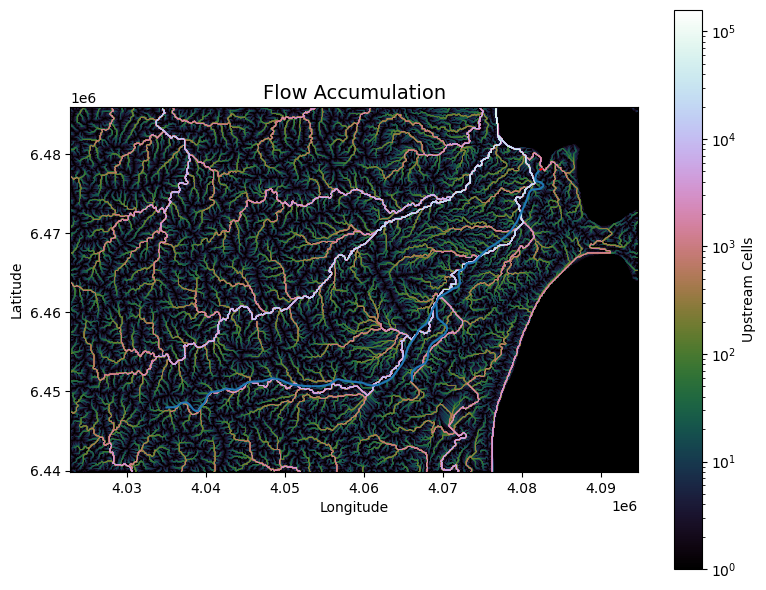

In [19]:
import matplotlib.pyplot as plt
from matplotlib import colors
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

rivers_brazil_shapefile[rivers_brazil_shapefile.estuary == 0].plot(ax = ax)
rivers_brazil_shapefile.loc[[(161,0,9)]].plot(ax = ax, color = "red")

---

In [ ]:
# spatial join to associate river network with drainage areas
# split where multiple rivers in one polygon
# dissolve by river

# - Opt A: Simple polygons (closest point)
# for each query point, find closest point on exterior of drainage area
# at end node, take residual part of drainage area
# use pysheds to generate weighting matrix

# - Opt B: Complex polygons (exact watershed)
# compute weighting matrices to find best fit sink point for each query point
# compute exact watershed for each query point within the drainage area

In [9]:
drainage_area = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_area.geojson", engine = "pyogrio")

In [264]:
threshold = 500

In [10]:
test = gpd.clip(drainage_area.to_crs(5641), grid_data.iloc[[525]].total_bounds)

In [11]:
joined = test.sjoin(rivers_brazil_shapefile, how="right", predicate = "intersects")
joined = joined[joined.index_left.notna()]

In [12]:
joined["intersection_length"] = joined.intersection(test.loc[joined.index_left], align=False).length

In [246]:
# a function to get shared downstream nodes given a list of rivers
def find_shared_nodes(river_ids):
    t_rivers = rivers_brazil_shapefile[rivers_brazil_shapefile.river.isin(river_ids)]
    t_downstream_node_counts = t_rivers.downstream_node_id.value_counts()
    t_confluence_nodes = t_downstream_node_counts[t_downstream_node_counts > 1].reset_index().downstream_node_id.apply(lambda x: rivers_brazil_topology.loc[x].geometry)
    t_confluence_rivers = t_downstream_node_counts[t_downstream_node_counts > 1].reset_index().downstream_node_id.apply(lambda x: t_rivers[t_rivers.downstream_node_id == x].river.values)
    # returns index_left -> shared downstream_node_id
    return t_confluence_nodes.to_list(), t_confluence_rivers.to_list()

In [265]:
# filter for those with multiple rivers of length longer than threshold in drainage polygon
to_fix = joined[joined.intersection_length > threshold].groupby("index_left").river.unique()
to_fix = to_fix[to_fix.map(len) > 1]
# get shared confluence nodes with corresponding rivers
to_fix = pd.DataFrame({"polygon_id": to_fix.index.to_list(), "river_ids": to_fix.values})
to_fix[["fix_confluence_points", "fix_confluence_rivers"]] = pd.DataFrame(to_fix.river_ids.apply(find_shared_nodes).tolist())

In [ ]:
# a function to expand bounds by a factor
def expand_bounds(bounds, factor = 1.5):
    return [bounds[0] - (bounds[2] - bounds[0]) * (factor - 1) / 2, bounds[1] - (bounds[3] - bounds[1]) * (factor - 1) / 2, bounds[2] + (bounds[2] - bounds[0]) * (factor - 1) / 2, bounds[3] + (bounds[3] - bounds[1]) * (factor - 1) / 2]

def get_catchment_polygon(query_node, grid):
    # get catchment area
    t_catchment = grid.catchment(x=query_node.x, y=query_node.y, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    # get polygons in image space
    polygon_image_space = cv2.findContours(np.array(t_catchment).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # affine transform to geospatial coordinates
    polygon_affine_space = shapely.affinity.affine_transform(shapely.geometry.Polygon(polygon_image_space[0][0].squeeze()).buffer(0), np.array(grid.affine)[[0,1,3,4,2,5]])
    return polygon_affine_space

def calculate_separation_score(distributions):
    # Calculate the absolute difference in class distribution between measuring points for each class
    class_diffs = np.abs(distributions[:, :, 0] - distributions[:, :, 1])
    # Calculate the balance for each class across measuring points
    total = distributions.sum(axis=2, keepdims=True) + 1e-9
    balances = 1 - np.abs(distributions / total - 0.5)
    # Combine the separation and balance scores
    separation_scores = class_diffs.mean(axis=1)
    balance_scores = balances.mean(axis=(1, 2))
    # Overall score considers both separation and balance, adjusting weights if necessary
    overall_scores = separation_scores * balance_scores
    return np.nan_to_num(overall_scores)

In [ ]:
# TODO
# make function
# do not make distinction betweem to_clip and residual, assign by river length

In [266]:
to_fix

,polygon_id,river_ids,fix_confluence_points,fix_confluence_rivers
0,24681.0,"[30813.0, 30734.0]",[POINT (2156687.708448134 8800728.992806045)],"[[30813.0, 30734.0]]"
1,25006.0,"[30890.0, 30887.0]",[POINT (2171405.100856631 8859611.24480142)],"[[30890.0, 30887.0]]"
2,25007.0,"[30888.0, 30889.0]",[POINT (2158214.7948203357 8839491.747117896)],"[[30888.0, 30889.0]]"
3,25039.0,"[30866.0, 30734.0]",[POINT (2239244.223228237 8871295.030740006)],"[[30866.0, 30734.0]]"
4,25040.0,"[30864.0, 30865.0]",[POINT (2241965.387613855 8863935.777215803)],"[[30864.0, 30865.0]]"
5,25070.0,"[30734.0, 30852.0]",[POINT (2171426.2228254303 8818605.042891283)],"[[30734.0, 30852.0]]"
6,74329.0,"[44839.0, 44840.0]",[POINT (2239664.9870722466 8794752.719323777)],"[[44839.0, 44840.0]]"
7,82693.0,"[44819.0, 44843.0]",[POINT (2248009.0176658053 8807411.32796086)],"[[44819.0, 44843.0]]"
8,82723.0,"[44835.0, 44836.0]",[POINT (2221586.3504960504 8795690.627597805)],"[[44835.0, 44836.0]]"
9,96137.0,"[44862.0, 44863.0]",[POINT (2250790.274712789 8787248.993160736)],"[[44862.0, 44863.0]]"


In [267]:
i = 0
c_payload = to_fix.iloc[i]

In [329]:
def get_upstream_drainage_polygon_ids(river_id, segment_id, n = 3):
    # get the n next river segments
    t_river_segments = rivers_brazil_shapefile.query(f"river=={river_id} & segment>={segment_id}").to_crs(4326)
    t_drainage_polygons = t_river_segments.sjoin(gpd.clip(drainage_area, t_river_segments.total_bounds)).sort_values("segment")
    return t_drainage_polygons.index_right.unique()[:n]

In [334]:
# dissolve river geometries of rivers at confluence
t_rivers_dissolved = rivers_brazil_shapefile[rivers_brazil_shapefile.river.isin(c_payload.river_ids)].dissolve("river").to_crs(4326)
# get current drainage polygon
c_drainage_polygon = drainage_area.loc[c_payload.polygon_id].geometry
# # unary union if multipolygon
# if isinstance(c_drainage_polygon, shapely.geometry.MultiPolygon):
#     c_drainage_polygon = shapely.unary_union(c_drainage_polygon.geoms).exterior

# get the river ids of rivers that are not entirely contained in the drainage polygon
c_river_ids_to_query = t_rivers_dissolved.index[~t_rivers_dissolved.within(c_drainage_polygon)].values
# get the geometries of the rivers to query, clipped to the drainage polygon
t_rivers_to_query = gpd.clip(rivers_brazil_shapefile[rivers_brazil_shapefile.river.isin(c_river_ids_to_query)].to_crs(4326), c_drainage_polygon)
# for each unique river, get the most upstream segment
t_rivers_to_query_max_segment = t_rivers_to_query.groupby("river").segment.max()
# get all upstream drainage polygons to include
c_upstream_drainage_polygons = np.unique([get_upstream_drainage_polygon_ids(i, x) for i, x in t_rivers_to_query_max_segment.items()])

In [ ]:
# ## LEGACY CODE
# ## get two upstream drainage polygon ids
# # identify rivers that do not end in the polygon
# clonger_river_id = to_fix.iloc[0][np.argmax([rivers_brazil_shapefile[rivers_brazil_shapefile.river == river_id].length.sum() for river_id in to_fix.iloc[0]])]
# #
# c_longer_river = rivers_brazil_shapefile[rivers_brazil_shapefile.river==clonger_river_id].to_crs(4326).sjoin(gpd.clip(drainage_area, rivers_brazil_shapefile[rivers_brazil_shapefile.river==clonger_river_id].to_crs(4326).total_bounds))
# upstream_drainage_polygons = c_longer_river[c_longer_river.segment >= c_longer_river[c_longer_river.index_right == to_fix_pp.index[0]].segment.max()].sort_values("segment").index_right.unique()[:3]

In [201]:

cheight_profile = height_profile.rio.clip_box(*expand_bounds(drainage_area.loc[upstream_drainage_polygons].to_crs(4326).total_bounds)).load()
cheight_profile = cheight_profile.rio.clip(drainage_area.loc[upstream_drainage_polygons].to_crs(5641).buffer(0).to_crs(4326).geometry)

with MemoryFile() as memfile:
    cheight_profile.fillna(cheight_profile.max()).rio.write_nodata(-32767).rio.to_raster(memfile.name)
    grid = Grid.from_raster(memfile.name, nodata=-32767)
    dem = grid.read_raster(memfile.name, mask_geometry=drainage_area.loc[to_fix_pp.index[0]].geometry.geoms)

# define direction vectors
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# get interval of height grid
grid_interval=cheight_profile.coords["y"][1].values - cheight_profile.coords["y"][0].values

# rivershed workflow @https://github.com/mdbartos/pysheds
# fill pits
pit_filled_dem = grid.fill_pits(dem)
# fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)
# resolve flats
inflated_dem = grid.resolve_flats(flooded_dem)
# compute flow direction
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
acc = grid.accumulation(fdir, dirmap=dirmap)

# extract river networks
extracted_river_network = gpd.GeoDataFrame(grid.extract_river_network(fdir, acc > 1000, dirmap=dirmap)["features"], crs = 4326)
# clip for current drainage are only
extracted_river_network = gpd.clip(extracted_river_network, drainage_area.loc[to_fix_pp.index[0]].geometry)
# get downstream nodes
extracted_river_network["end_node"] = extracted_river_network.apply(lambda x: shapely.Point(x["geometry"].coords[-1]), axis = 1)
# get upstream nodes
extracted_river_network["query_node"] = extracted_river_network.apply(lambda x: shapely.Point(x["geometry"].coords[-2]), axis = 1)
extracted_river_network["start_node"] = extracted_river_network.apply(lambda x: shapely.Point(x["geometry"].coords[0]), axis = 1)
# compute and merge in occurence counts (confluence can be infered from double occurence of downstream node)
extracted_river_network = pd.merge(extracted_river_network, extracted_river_network.apply(lambda x: shapely.Point(x["geometry"].coords[-1]), axis = 1).value_counts().sort_values(), left_on="end_node", right_index=True)

# get multiple occurences
query_points = extracted_river_network[extracted_river_network["count"] > 1].groupby("end_node").query_node.apply(lambda x: x.to_list()).reset_index()
# get catchment polygons for each query node
query_points["drainage_polygons"] = query_points.query_node.apply(lambda x: [get_catchment_polygon(y, grid) for y in x])
# check length of intersection between catchment polygons and dissolved river geometries
query_points["drainage_river_distribution"] = query_points.drainage_polygons.apply(lambda x: np.array([y.intersection(t_rivers_dissolved.geometry).length for y in x]))
# normalize to distribution
query_points["drainage_river_distribution_p"] = query_points["drainage_river_distribution"] / query_points["drainage_river_distribution"].apply(lambda x: np.sum(x, axis = 0))
# calculate separation score
query_points["distribution_score"] = calculate_separation_score_optimized(np.stack(query_points["drainage_river_distribution_p"]))

# get id of shorter river
t_idx_shorter_river = t_rivers_dissolved.to_crs(5641).reset_index().length.idxmin()
# get id of top score
t_idx_top_score = query_points.distribution_score.idxmax()
# get the id of the polygon to clip
t_idx_polygon_to_clip = np.argmax(query_points.loc[t_idx_top_score,"drainage_river_distribution_p"], axis=1)[t_idx_shorter_river]
# get the polygon to clip
t_clip = query_points.loc[t_idx_top_score].drainage_polygons[t_idx_polygon_to_clip]
# clip the existing polygon
t_residual = drainage_area.loc[to_fix.index[0]].geometry.difference(t_clip)
# clean residual
if isinstance(t_residual, shapely.geometry.multipolygon.MultiPolygon):
    t_residual = t_residual.geoms[np.argmax([x.length for x in t_residual.geoms])]

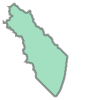

In [202]:
t_clip

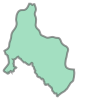

In [203]:
t_residual

In [ ]:
# ## EXPERIMENTAL

# # check alignment for query points
# ii = 5
# fig, ax = plt.subplots(figsize=(8,6))
# xr.DataArray(acc, coords = cheight_profile.coords, dims = cheight_profile.dims).rio.clip([extracted_river_network.iloc[ii].end_node.buffer(.01)]).plot.imshow(ax = ax)
# gpd.GeoSeries([shapely.Point([extracted_river_network.iloc[ii].end_node.x-0.5*grid_interval,
#                               extracted_river_network.iloc[ii].end_node.y+0.5*grid_interval])]).plot(ax = ax, color = "red")
# gpd.GeoSeries([shapely.Point([extracted_river_network.iloc[ii].query_node.x-0.5*grid_interval,
#                               extracted_river_network.iloc[ii].query_node.y+0.5*grid_interval])]).plot(ax = ax, color = "red")
#gpd.GeoSeries(query_points.iloc[6]).plot(ax = ax, color = "red")

# def get_point(x):
#     return xr.DataArray(acc, coords = cheight_profile.coords, dims = cheight_profile.dims).sel(x = x.x-0.5*grid_interval,
#                                                                                     y = x.y+0.5*grid_interval,
#                                                                                     method = "nearest").values

# # get centrality weight
# query_points["centrality_weight"] = query_points.query_node.apply(lambda x: np.mean(np.log10([get_point(y) for y in x])))
# query_points = gpd.GeoDataFrame(query_points.rename(columns = {"end_node": "geometry"}))
# # get distance weight
# query_points["distance_weight"] = -query_points.distance(gpd.GeoSeries(to_fix_pp.iloc[0], crs=5641).to_crs(4326).values[0])
# # compute final score
# query_points["score"] = ((query_points[["centrality_weight", "distance_weight"]] - query_points[["centrality_weight", "distance_weight"]].mean()) / query_points[["centrality_weight", "distance_weight"]].std()).sum(axis=1)

# # angle at confluence
# c_end_start = defaultdict(list)
# for i, x in gpd.clip(extracted_river_network, drainage_area.loc[[to_fix.index[0]]].geometry).iterrows():
#     c_end_start[x.end_node].append(x.start_node)
# c_end_start = dict(c_end_start)
# c_candidate_norm = []
# for i, x in query_points.iterrows():
#     c_query_init = c_end_start[x.geometry]
#     c_end_nodes = []
#     for init_point in c_query_init:
#         c_query = [init_point]
#         c_query_ends = []
#         while c_query:
#             c_query_item = c_query.pop()
#             c_query_results = c_end_start.get(c_query_item, None)
#             if c_query_results is not None:
#                 for c_query_result in c_query_results:
#                     c_query.append(c_query_result)
#             else:
#                 c_query_ends.append(c_query_item)
#         c_query_ends_distances = [init_point.distance(x) for x in c_query_ends]
#         c_end_nodes.append(c_query_ends[np.argmax(c_query_ends_distances)].coords)
#     t_characteristics = np.concatenate(c_end_nodes) - x.geometry.coords
#     t_characteristics = np.arctan2(t_characteristics[:,1], t_characteristics[:,0])
#     c_candidate_norm.append(np.column_stack((np.ones(2) * np.cos(t_characteristics), np.ones(2) * np.sin(t_characteristics))))
# #
# c_edges = rivers_brazil_shapefile[rivers_brazil_shapefile.downstream_node_id == find_shared_nodes(to_fix.iloc[0])[0]]
# #
# t_shapefile = gpd.clip(rivers_brazil_shapefile, drainage_area.loc[[to_fix.index[0]]].to_crs(5641).geometry)
# c_upstream_nodes = [t_shapefile[((t_shapefile.river == c_edges.river.iloc[0]) & (t_shapefile.segment >= c_edges.segment.iloc[0]))].sort_values("segment").iloc[-1].geometry.coords[0],
#                     t_shapefile[((t_shapefile.river == c_edges.river.iloc[1]) & (t_shapefile.segment >= c_edges.segment.iloc[1]))].sort_values("segment").iloc[-1].geometry.coords[0]]
# #
# c_upstream_nodes_vectors = np.array(c_upstream_nodes) - np.array(to_fix_pp.iloc[0][0].coords)
# #
# c_upstream_nodes_angles = np.arctan2(c_upstream_nodes_vectors[:, 1], c_upstream_nodes_vectors[:, 0])
# # convert back to Cartesian coordinates
# c_true_norm = np.column_stack((np.ones(2) * np.cos(c_upstream_nodes_angles), np.ones(2) * np.sin(c_upstream_nodes_angles)))
# import matplotlib.pyplot as plt
# # Create figure and axis
# fig, ax = plt.subplots()

# query_points.loc[[query_points.score.idxmax()]].\
#     apply(lambda x: [((np.array(x.geometry.coords) - np.array(query_node.coords))[0]) for query_node in x.query_node], axis = 1).\
#         apply(lambda x: [np.arctan2(*(y / np.linalg.norm(y))[::-1]) * 180 / np.pi for y in x])

# # Plot unit circle
# circle = plt.Circle((0, 0), 1, color='black', fill=False)
# ax.add_artist(circle)

# # Plot vector
# ax.quiver(0, 0, c_true_norm[0,0], c_true_norm[0,1], angles='xy', scale_units='xy', scale=1, color='blue')
# ax.quiver(0, 0, c_true_norm[1,0], c_true_norm[1,1], angles='xy', scale_units='xy', scale=1, color='blue')

# ax.quiver(0, 0, c_candidate_norm[4][0,0], c_candidate_norm[4][0,1], angles='xy', scale_units='xy', scale=1, color='red')
# ax.quiver(0, 0, c_candidate_norm[4][1,0], c_candidate_norm[4][1,1], angles='xy', scale_units='xy', scale=1, color='red')

# # Set aspect ratio to be equal
# ax.set_aspect('equal')

# # Set limits
# ax.set_xlim(-1.5, 1.5)
# ax.set_ylim(-1.5, 1.5)

# # Function to calculate cosine similarity between two vectors
# def cosine_similarity(vecA, vecB):
#     normA = np.linalg.norm(vecA)
#     normB = np.linalg.norm(vecB)
#     return np.dot(vecA, vecB) / (normA * normB)

# # Calculate similarities
# similarity_scores = []
# for pair in c_candidate_norm:
#     # Calculate similarity for both possible orderings
#     sim1 = (cosine_similarity(pair[0], c_true_norm[0]) + cosine_similarity(pair[1], c_true_norm[1])) / 2
#     sim2 = (cosine_similarity(pair[0], c_true_norm[1]) + cosine_similarity(pair[1], c_true_norm[0])) / 2
#     # Select the highest similarity score
#     similarity_scores.append(max(sim1, sim2))

# similarity_scores

# clonger_river = rivers_brazil_shapefile[rivers_brazil_shapefile.river.isin(to_fix.iloc[0])].length.groupby(rivers_brazil_shapefile[rivers_brazil_shapefile.river.isin(to_fix.iloc[0])].river).sum().idxmax()
# c_projection_line = gpd.clip(rivers_brazil_shapefile[rivers_brazil_shapefile.river == clonger_river].to_crs(4326),  
#          drainage_area.loc[to_fix_pp.index[0]].geometry).dissolve().geometry.iloc[0]
# c_projection_line = shapely.ops.linemerge(c_projection_line).reverse()
# query_points["origin_correction_weight"] = query_points.geometry.apply(lambda x: c_projection_line.project(x))

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

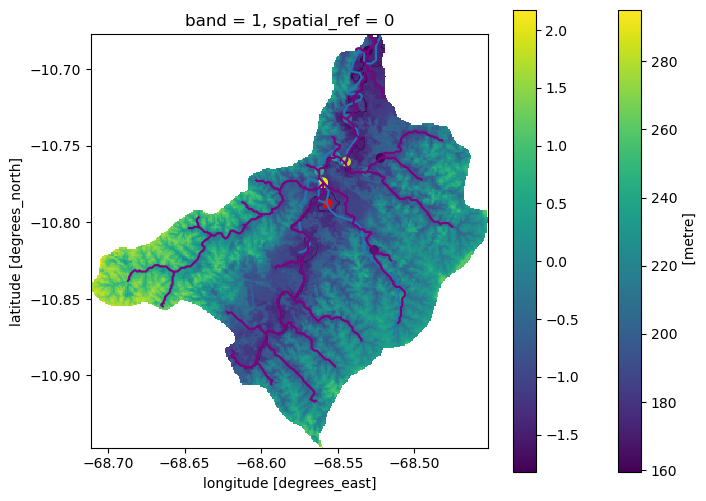

In [207]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
cheight_profile.plot.imshow(ax =ax)
gpd.clip(rivers_brazil_shapefile[rivers_brazil_shapefile.river.isin(to_fix.iloc[0])].to_crs(4326), drainage_area.loc[[to_fix_pp.index[0]]].total_bounds).plot(ax = ax)
gpd.GeoSeries(to_fix_pp.iloc[0], crs=5641).to_crs(4326).plot(ax = ax, color = "red")
extracted_river_networks[2].plot(ax=ax, color="purple")
query_points.plot(ax =ax, column="score", legend=True)

In [ ]:
with MemoryFile() as memfile:
    cheight_profile.rio.write_nodata(-32767).rio.to_raster(memfile.name)
    grid = Grid.from_raster(memfile.name)
    dem = grid.read_raster(memfile.name)

In [ ]:
# Workflow @https://github.com/mdbartos/pysheds
# fill pits
pit_filled_dem = grid.fill_pits(dem)
# fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)
# resolve flats
inflated_dem = grid.resolve_flats(flooded_dem)
# compute flow direction
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
acc = grid.accumulation(fdir, dirmap=dirmap)
# extract river networks
extracted_river_networks = [gpd.GeoDataFrame(grid.extract_river_network(fdir, acc > t, dirmap=dirmap)["features"]) for t in [10, 100, 1000]]

In [183]:
rivers_brazil_topology.loc[to_fix.apply(worker).explode()]

,estuary,confluence,source,border,geometry
22853,False,True,False,False,POINT (2156687.708 8800728.993)
23215,False,True,False,False,POINT (2171405.101 8859611.245)
22896,False,True,False,False,POINT (2158214.795 8839491.747)
24924,False,True,False,False,POINT (2239244.223 8871295.031)
24993,False,True,False,False,POINT (2241965.388 8863935.777)
23216,False,True,False,False,POINT (2171426.223 8818605.043)
24941,False,True,False,False,POINT (2239664.987 8794752.719)
25131,False,True,False,False,POINT (2248009.018 8807411.328)
24439,False,True,False,False,POINT (2221586.350 8795690.628)
25193,False,True,False,False,POINT (2250790.275 8787248.993)


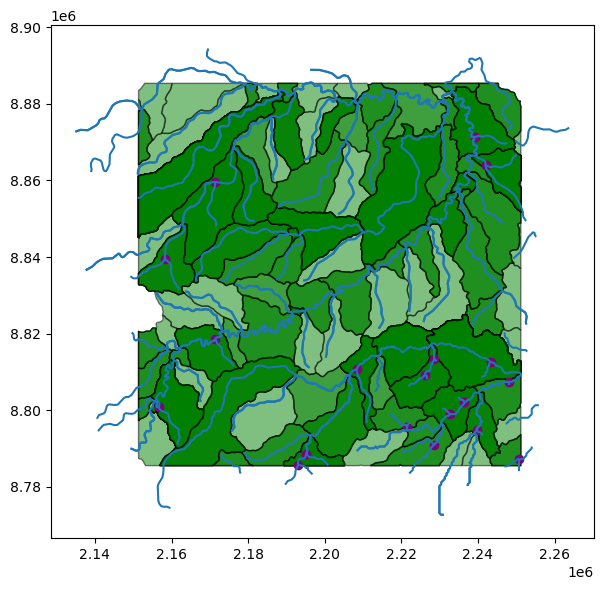

In [175]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
test.loc[joined[~joined.index_left.isna()].index_left].plot(ax=ax, color="green", edgecolor="black", legend=True, alpha=.5)
joined[~joined.index_left.isna()].plot(ax=ax)
rivers_brazil_topology.loc[to_fix.apply(worker).explode()].plot(ax=ax, color="purple")
fig.tight_layout()

In [47]:
joined["intersection_length"] = joined.intersection(rivers_brazil_shapefile.loc[joined.apply(lambda x: tuple([x.index_right0, x.index_right1, x.index_right2]), axis = 1)], align=False).length

In [103]:
joined[joined.intersection_length == 0]

,OBJECTID,IDBACIA,COTRECHO,COCURSODAG,COBACIA,NUAREACONT,NUORDEMCDA,NUNIVOTTO1,NUNIVOTTO2,NUNIVOTTO3,...,upstream_node_id,adm2,estuary,river,segment,subsegment,segment_offset,length,intersection_length,intersection_number
25072,25073,25061,33656,4926812,4926812,139.554,5.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,1.0
24984,24985,24983,27451,4926628,4926628,109.038,6.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,2.0
74786,74787,74616,26663,4926626,4926626,65.365,6.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,NaN
24987,24988,24986,27458,492662,4926629,168.640,5.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,NaN
24982,24983,24981,33511,492662,4926625,171.394,5.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,NaN
24982,24983,24981,33511,492662,4926625,171.394,5.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,NaN
24982,24983,24981,33511,492662,4926625,171.394,5.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,NaN
24982,24983,24981,33511,492662,4926625,171.394,5.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,NaN
24982,24983,24981,33511,492662,4926625,171.394,5.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,NaN
24983,24984,24982,33503,492662,4926627,6.174,5.0,4,49,492,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.0,0.0,1.0


In [62]:
joined[joined.intersection_length > 0].groupby("OBJECTID").river.nunique()

OBJECTID
1577      2
2884      1
3153      1
3179      3
3563      3
         ..
96167     2
96168     3
96169     1
108507    1
110697    2
Name: river, Length: 99, dtype: int64

In [68]:
pd.merge(joined, joined[joined.intersection_length > 0].groupby("OBJECTID").river.nunique(), left_on="OBJECTID", right_index=True, how="left")

,OBJECTID,IDBACIA,COTRECHO,COCURSODAG,COBACIA,NUAREACONT,NUORDEMCDA,NUNIVOTTO1,NUNIVOTTO2,NUNIVOTTO3,...,adm2,estuary,river_x,segment,subsegment,segment_offset,length,intersection_length,intersection_number,river_y
24683,24684,24682,33700,4926,49269115,126.436,3.0,4,49,492,...,6.0,136.0,30734.0,62.0,0.0,35.125206,16807.043066,16807.043066,NaN,1
25074,25075,25063,33618,49269114,49269114,66.944,4.0,4,49,492,...,6.0,136.0,30734.0,61.0,0.0,65.987464,94.661519,94.661519,NaN,2
25074,25075,25063,33618,49269114,49269114,66.944,4.0,4,49,492,...,6.0,136.0,30734.0,62.0,0.0,35.125206,89.335626,89.335626,NaN,2
25074,25075,25063,33618,49269114,49269114,66.944,4.0,4,49,492,...,6.0,136.0,30812.0,0.0,0.0,35.125206,6067.384300,6067.384300,NaN,2
25072,25073,25061,33656,4926812,4926812,139.554,5.0,4,49,492,...,6.0,136.0,30851.0,1.0,0.0,76.008965,6913.036912,6913.036912,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20294,20295,20215,33640,4926,49267931,99.878,3.0,4,49,492,...,21.0,136.0,30734.0,45.0,0.0,9.047235,12.088609,12.088609,NaN,2
25066,25067,25055,25725,4926796,4926796,116.366,4.0,4,49,492,...,21.0,136.0,30854.0,0.0,0.0,65.592915,20441.004341,20441.004341,2.0,1
25063,25064,25051,27569,4926,4926791,139.127,3.0,4,49,492,...,21.0,136.0,30858.0,0.0,0.0,9.047235,86.972605,86.972605,1.0,2
25063,25064,25051,27569,4926,4926791,139.127,3.0,4,49,492,...,21.0,136.0,30734.0,45.0,0.0,9.047235,18431.391133,18431.391133,1.0,2


In [61]:
joined["intersection_number"] = joined[joined.intersection_length > 0].groupby("OBJECTID").river.nunique()

In [101]:
joined[joined.intersection_length > 1000].groupby("OBJECTID").river.nunique()

OBJECTID
1577      1
2884      1
3153      1
3179      1
3563      1
         ..
96167     1
96168     2
96169     1
108507    1
110697    1
Name: river, Length: 97, dtype: int64

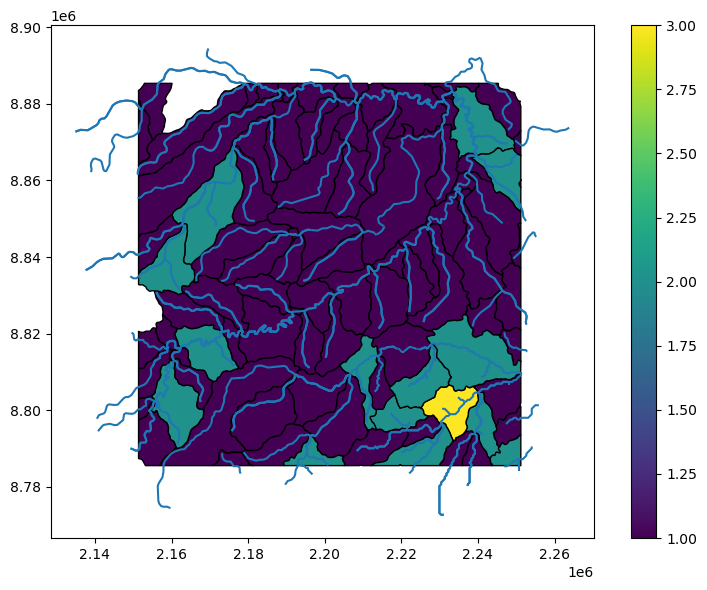

In [99]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
pd.merge(joined.groupby("OBJECTID", as_index=False).geometry.first(), joined[joined.intersection_length > 1000].groupby("OBJECTID").river.nunique(), left_on="OBJECTID", right_index=True, how="left").plot(ax =ax, column="river", edgecolor="black", legend=True)
rivers_brazil_shapefile.loc[joined.apply(lambda x: tuple([x.index_right0, x.index_right1, x.index_right2]), axis = 1)].plot(ax = ax)
fig.tight_layout()

In [98]:
0.02e6


20000.0

In [21]:
test.sjoin(rivers_brazil_shapefile).groupby("OBJECTID").river.nunique()

OBJECTID
1577      2
2884      1
3153      1
3179      3
3563      3
         ..
96167     2
96168     3
96169     1
108507    1
110697    2
Name: river, Length: 99, dtype: int64

<Axes: >

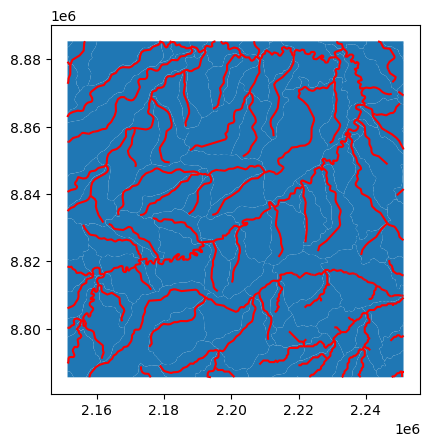

In [124]:
ax = gpd.clip(test.to_crs(5641), grid_data.iloc[[525]].total_bounds).plot()
gpd.clip(rivers_brazil_shapefile, grid_data.iloc[[525]].total_bounds).plot(ax = ax, color = "red")

---

In [22]:
test = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/test_polygons.pkl", "rb"))

In [49]:
out_polygons = defaultdict(list)

def get_polygons(payload):
    ## payload: (current_node_id)
    
    ## get current node and offset
    cedge = geometry_lookup.get(payload[0], None)
    coffset = offset_lookup.get(payload[0], None)
    
    ## cut the edge into segments
    # get number of cuts
    ccuts = int((cedge.length + coffset) // cut_length)
    # get points to snap
    if ccuts == 0:
        to_snap = np.concatenate([np.array(cedge.coords[0]).reshape(1,-1), np.array(cedge.coords[-1]).reshape(1,-1)])
    else:
        to_snap = np.concatenate([np.array(cedge.coords[0]).reshape(1,-1), np.array([cedge.interpolate(cut_length * (i + 1)).coords for i in range(ccuts)]).squeeze(), np.array(cedge.coords[-1]).reshape(1,-1)])
    
    ## iteratively snap points to the extracted river networks
    # get the nearest points on the extracted river networks
    closest_points = np.stack([shapely.ops.nearest_points(np.apply_along_axis(shapely.geometry.Point, 1, to_snap), shapely.geometry.MultiLineString(extracted_river_networks[i].geometry.to_list())) for i in range(len(extracted_river_networks))])
    # extract coordinates from points
    closest_points = np.array([[[(point.x, point.y) for point in row] for row in plane] for plane in closest_points])
    # calculate distances between points and compare to threshold
    within_threshold = np.flip(np.sqrt(np.power((closest_points[:,1,:,:] - closest_points[:,0,:,:]), 2).sum(axis=2)) < 500, axis=0)
    # add row of ones to choose the original point if no point is within threshold
    within_threshold = np.vstack([within_threshold, np.ones(within_threshold.shape[1])])
    # get the index of the closest point
    snapped_point_index = len(extracted_river_networks) - np.argmax(within_threshold, axis=0)
    # add original point to the closest points
    point_matrix = np.concatenate([closest_points[[0],0,:,:], closest_points[:,1,:,:]])
    # get the snapped points
    snapped = np.array([point_matrix[snapped_point_index[i], i, :] for i in range(len(snapped_point_index))])
    
    ## extract catchment polygons
    # get catchment areas
    masks = [grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate') * 1 for x_snap, y_snap in snapped]

    # get polygons in image space
    polygons_image_space = [cv2.findContours(np.array(mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) for mask in masks]

    # affine transform to geospatial coordinates
    polygons_affine_space = [shapely.affinity.affine_transform(shapely.geometry.Polygon(contours[0][0].squeeze()).buffer(0), np.array(grid.affine)[[0,1,3,4,2,5]]) for contours in polygons_image_space]

    # difference to get individual polygons
    polygons_affine_space_differenced = [polygons_affine_space[i].difference(polygons_affine_space[i-1]) for i in range(1, len(polygons_affine_space))]#range(len(polygons_affine_space)-1, 0, -1)
    
    # if not all([x.is_empty for x in polygons_affine_space_differenced]):
    #     ## detect outliers
    #     # get areas of polygons
    #     polygons_affine_space_differenced_areas = [x.area for x in polygons_affine_space_differenced]

    #     # Calculate the interquartile range (IQR)
    #     Q3 = np.percentile(polygons_affine_space_differenced_areas[:-1:], 75)
    #     IQR = Q3 - np.percentile(polygons_affine_space_differenced_areas[:-1:], 25)

    #     # Find outliers based on the threshold
    #     outliers = polygons_affine_space_differenced_areas > Q3 + 1.5 * IQR
    #     outliers_fixes = 
    # else :
    #     outliers = np.array([False] * len(polygons_affine_space_differenced))
    
    return polygons_affine_space_differenced, polygons_affine_space[0]#, {payload[0]: outliers}

In [52]:
out_polygons

defaultdict(list,
            {(161, 0, 9): <filter at 0x14b2c81bd490>,
             (161, 0, 7): <filter at 0x14b2c81bddc0>,
             (161, 0, 6): <filter at 0x14b2c80ae0d0>,
             (161, 0, 4): <filter at 0x14b2b9a45e20>,
             (161, 0, 2): <filter at 0x14b2c863e0a0>,
             (161, 0, 0): <filter at 0x14b2c863e4c0>,
             (46784, 0, 2): <filter at 0x14b2c80578b0>,
             (46784, 0, 0): <filter at 0x14b2c80a3070>})

In [124]:
rivers_brazil_shapefile.query("estuary==0")

NORIOCOMP    CORIO  downstream_node_id  upstream_node_id  \
161   0 0  Arroio Araçá  79732_0            363033.0          494232.0   
        2  Arroio Araçá  79732_0            363036.0          363033.0   
        4  Arroio Araçá  79732_0            363038.0          363036.0   
        6  Arroio Araçá  79732_0             77149.0          363038.0   
        7  Arroio Araçá  79732_0            363037.0           77149.0   
        9  Arroio Araçá  79732_0                 NaN          363037.0   
46784 0 0          None     None            364849.0          495224.0   
        2          None     None             77149.0          364849.0   

             adm2  estuary  river  segment  subsegment  \
161   0 0  3952.0      0.0    0.0      5.0         0.0   
        2  4280.0      0.0    0.0      4.0         0.0   
        4  4294.0      0.0    0.0      3.0         0.0   
        6  3888.0      0.0    0.0      2.0         0.0   
        7  3888.0      0.0    0.0      1.0         0.0   
        9  4080.0      0.0    0.0      0.0         0.0   
46784 0 0  4294.0      0.0    1.0      1.0         0.0   
        2  3888.0      0.0    1.0      0.0         0.0   

                                                    geometry segment_offset  
161   0 0  LINESTRING (4034906.284 6447982.452, 4036031.7...      798.91198  
        2  LINESTRING (4036818.871 6448452.434, 4036920.0...     896.754078  
        4  LINESTRING (4053374.435 6450672.398, 4054381.8...     619.182053  
        6  LINESTRING (4066241.034 6456521.694, 4066540.6...      60.843182  
        7  LINESTRING (4069134.173 6461147.929, 4069450.8...     445.736194  
        9  LINESTRING (4082246.887 6477972.224, 4082331.6...            0.0  
46784 0 0  LINESTRING (4066170.464 6451222.482, 4066081.3...     292.557335  
        2  LINESTRING (4070384.499 6457502.235, 4070543.9...      60.843182

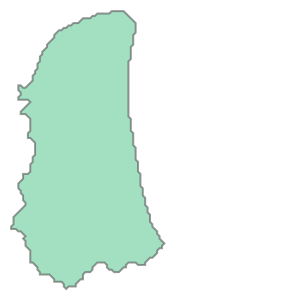

In [53]:
def recursion(payload):
    ## payload: (current_node)
    
    # get current polygons
    cpolygons, ctotal_polygon = get_polygons([payload[0]])
    out_polygons[payload[0]] = list(filter(lambda x: not x.is_empty, cpolygons))
    
    # recursive call if not end node
    if not end_node_lookup.get(upstream_lookup.get(payload[0], None), False):
        # get all upstream river ids
        cupstream_edges = downstream_lookup.get(upstream_lookup.get(payload[0], None), [])
        ## prepare list for upstream outlier indices
        #cupstream_outliers = [None] * len(cupstream_edges)
        # iterate over upstream rivers
        for i in range(len(cupstream_edges)):
            tupstream_total_polygon = recursion([cupstream_edges[i]]) #, cupstream_outliers[i]
            cpolygons[-1] = cpolygons[-1].difference(tupstream_total_polygon)
        # if len(cupstream_edges) == 1:
        #     for d in cupstream_outliers:
        #         c_outliers.update(d)
        #     return ctotal_polygon, c_outliers
        # if len(cupstream_edges) > 1:
        #     cure = [[np.array(out_polygons[key])[np.logical_not(val)] for key, val in ccupstream_outliers.items()] for ccupstream_outliers in cupstream_outliers]
        #     to_treat = [{key: np.where(val)[0] for key, val in ccupstream_outliers.items()} for ccupstream_outliers in cupstream_outliers]
        #     for i in range(len(cupstream_edges)):
        #         for key, val in to_treat[i].items():
        #             for cval in val:
                        
        #                 out_polygons[key][cval] = out_polygons[key][cval].difference(shapely.geometry.Polygon(itertools.chain.from_iterable([[x] if isinstance(x, shapely.geometry.Polygon) else x.geoms for x in itertools.chain.from_iterable(cure[-i])])))
        #         cpolygons[-1] = shapely.ops.difference(cpolygons[-1], cure[i])
        #     # TODO: merge total polygons
        #     return ctotal_polygon, c_outliers
    return ctotal_polygon#, c_outliers
        
recursion([(161, 0, 9)])

In [99]:
cpolygons = out_polygons[(161,0,7)]

In [100]:
cpolygons_areas = [x.area for x in cpolygons]
Q3 = np.percentile(cpolygons_areas, 75)
IQR = Q3 - np.percentile(cpolygons_areas, 25)
outliers = cpolygons_areas > Q3 + 1.5 * IQR

In [79]:
np.round(cpolygons_areas / (Q3 + 1000 * IQR), 0)

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<Axes: >

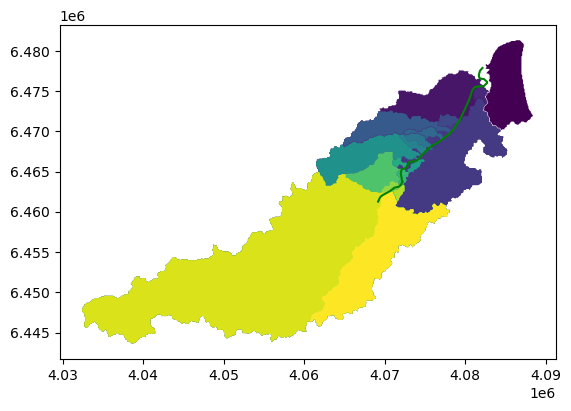

In [102]:
ax = gpd.GeoSeries(np.array(cpolygons)[outliers][::-1]).reset_index().plot(column="index")
gpd.GeoSeries([geometry_lookup.get((161,0,7))]).plot(ax = ax, color = "green")

In [ ]:
    #     polygons_affine_space_differenced_areas = [x.area for x in polygons_affine_space_differenced]

    #     # Calculate the interquartile range (IQR)
    #     Q3 = np.percentile(polygons_affine_space_differenced_areas[:-1:], 75)
    #     IQR = Q3 - np.percentile(polygons_affine_space_differenced_areas[:-1:], 25)

    #     # Find outliers based on the threshold
    #     outliers = polygons_affine_space_differenced_areas > Q3 + 1.5 * IQR

<Axes: >

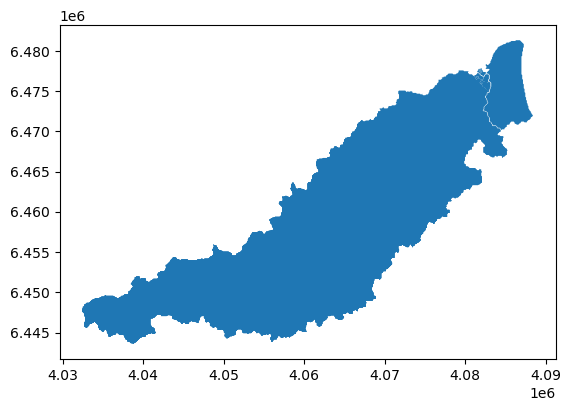

In [56]:
gpd.GeoSeries(out_polygons[(161,0,7)]).plot()

<Axes: >

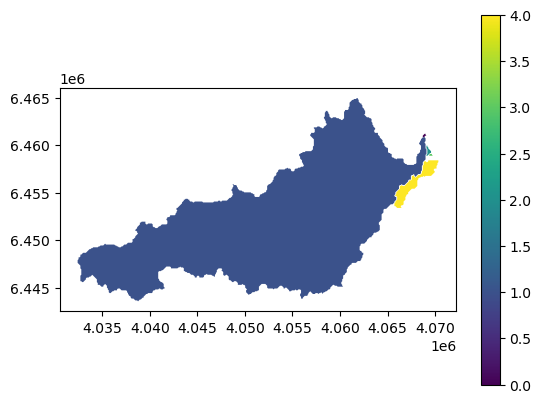

In [132]:
gpd.GeoDataFrame(geometry=get_polygons([(46784,0,2)])[0]).reset_index().plot(column="index", legend=True)

In [114]:
rivers_brazil_shapefile.query("estuary==0")
cedge = geometry_lookup.get((46784,0,0))
coffset = offset_lookup.get((46784,0,0))

In [116]:
## cut the edge into segments
# get number of cuts
ccuts = int((cedge.length + coffset) // cut_length)
# get points to snap
to_snap = np.concatenate([np.array(cedge.coords[0]).reshape(1,-1), np.array([cedge.interpolate(cut_length * (i + 1)).coords for i in range(ccuts)]).squeeze(), np.array(cedge.coords[-1]).reshape(1,-1)])

In [117]:
## iteratively snap points to the extracted river networks
# get the nearest points on the extracted river networks
closest_points = np.stack([shapely.ops.nearest_points(np.apply_along_axis(shapely.geometry.Point, 1, to_snap), shapely.geometry.MultiLineString(extracted_river_networks[i].geometry.to_list())) for i in range(len(extracted_river_networks))])
# extract coordinates from points
closest_points = np.array([[[(point.x, point.y) for point in row] for row in plane] for plane in closest_points])
# calculate distances between points and compare to threshold
within_threshold = np.flip(np.sqrt(np.power((closest_points[:,1,:,:] - closest_points[:,0,:,:]), 2).sum(axis=2)) < 500, axis=0)
# add row of ones to choose the original point if no point is within threshold
within_threshold = np.vstack([within_threshold, np.ones(within_threshold.shape[1])])
# get the index of the closest point
snapped_point_index = len(extracted_river_networks) - np.argmax(within_threshold, axis=0)
# add original point to the closest points
point_matrix = np.concatenate([closest_points[[0],0,:,:], closest_points[:,1,:,:]])
# get the snapped points
snapped = np.array([point_matrix[snapped_point_index[i], i, :] for i in range(len(snapped_point_index))])#gpd.GeoSeries(np.apply_along_axis(shapely.geometry.Point, 1, [point_matrix[snapped_point_index[i], i, :] for i in range(len(snapped_point_index))]), crs=5641).to_crs(4326)

In [118]:
# get catchment areas
masks = [grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate') * 1 for x_snap, y_snap in snapped]

# get polygons in image space
polygons_image_space = [cv2.findContours(np.array(mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) for mask in masks]

# affine transform to geospatial coordinates
polygons_affine_space = [shapely.affinity.affine_transform(shapely.geometry.Polygon(contours[0][0].squeeze()), np.array(grid.affine)[[0,1,3,4,2,5]]) for contours in polygons_image_space]

# difference to get individual polygons
polygons_affine_space_differenced = [polygons_affine_space[i].difference(polygons_affine_space[i-1]) for i in range(len(polygons_affine_space)-1, 0, -1)]

<Axes: >

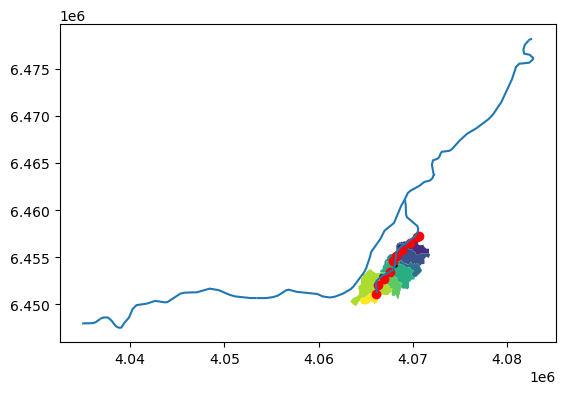

In [119]:
ax = rivers_brazil_shapefile[rivers_brazil_shapefile.estuary == 0].plot()
gpd.GeoDataFrame(geometry = polygons_affine_space_differenced).reset_index().plot(ax = ax, column = "index")
gpd.GeoSeries([cedge.interpolate(1000 * (i + 1)) for i in range(ccuts)]).plot(ax = ax, color = "black", markersize=5)
gpd.GeoSeries(np.apply_along_axis(Point, 1, snapped)).plot(ax = ax, color = "red")
#gpd.GeoSeries().plot(ax = ax, color = "orange")

#ax.set_xlim(4.2e6, 4.22e6)
#ax.set_ylim(7.49e6, 7.505e6)

---

In [9]:
from pysheds.grid import Grid

grid = Grid.from_raster("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/Copernicus_DSM_30_S23_00_W051_00/DEM/Copernicus_DSM_30_S23_00_W051_00_DEM_t.tif")
dem = grid.read_raster("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/Copernicus_DSM_30_S23_00_W051_00/DEM/Copernicus_DSM_30_S23_00_W051_00_DEM_t.tif")

NameError: name 'polygons_affine_space' is not defined

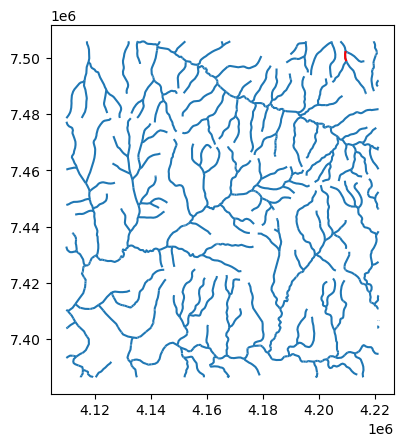

In [15]:
rivers_subset = gpd.clip(rivers_brazil_shapefile, np.array(grid.extent)[[0,2,1,3]])

ax = rivers_subset.plot()
rivers_subset.loc[[(37937,0,9)]].plot(ax = ax, color = "red")
gpd.GeoSeries(polygons_affine_space).plot(ax = ax, color = "purple")
gpd.GeoSeries([polygons_affine_space[1].difference(polygons_affine_space[0])]).plot(ax = ax, color = "pink")
gpd.GeoSeries([shapely.geometry.Point(iterative_snap(x)[0]) for x in to_snap]).plot(ax = ax, color = "black")

rivers_subset.loc[[(15398, 0, 0)]].plot(ax = ax, color = "green")
gpd.GeoSeries([cedge.interpolate(1000 * (i + 1)) for i in range(ccuts)], crs=5641).to_crs(4326).plot(ax=ax, color = "black", markersize=5)

ax.set_xlim(4.2e6, 4.22e6)
ax.set_ylim(7.49e6, 7.505e6)

In [13]:
cedge = rivers_brazil_shapefile.loc[15398, 0, 0].geometry
coffset = rivers_brazil_shapefile.loc[15398, 0, 0].segment_offset

In [14]:
ccuts = int((cedge.length + coffset) // 1000)
noffset = (cedge.length + coffset) % 1000
to_snap = np.concatenate([np.array(cedge.coords[0]).reshape(1,-1), np.array([cedge.interpolate(1000 * (i + 1)).coords for i in range(ccuts)]).squeeze(), np.array(cedge.coords[-1]).reshape(1,-1)])

In [296]:
extracted_river_networks = [gpd.GeoDataFrame(grid.extract_river_network(fdir, acc > t, dirmap=dirmap)["features"]) for t in [10, 100, 1000]]

In [297]:
# get the nearest points on the extracted river networks
closest_points = np.stack([shapely.ops.nearest_points(np.apply_along_axis(shapely.geometry.Point, 1, to_snap), shapely.geometry.MultiLineString(extracted_river_networks[i].geometry.to_list())) for i in range(len(extracted_river_networks))])
# extract coordinates from points
closest_points = np.array([[[(point.x, point.y) for point in row] for row in plane] for plane in closest_points])
# calculate distances between points and compare to threshold
within_threshold = np.flip(np.sqrt(np.power((closest_points[:,1,:,:] - closest_points[:,0,:,:]), 2).sum(axis=2)) < 500, axis=0)
# add row of ones to choose the original point if no point is within threshold
within_threshold = np.vstack([within_threshold, np.ones(within_threshold.shape[1])])
# get the index of the closest point
snapped_point_index = len(extracted_river_networks) - np.argmax(within_threshold, axis=0)
# add original point to the closest points
point_matrix = np.concatenate([closest_points[[0],0,:,:], closest_points[:,1,:,:]])
# get the snapped points
snapped = np.array([point_matrix[snapped_point_index[i], i, :] for i in range(len(snapped_point_index))])

In [68]:
def iterative_snap(to_snap):
    # minimum cumulative upstream cell threshold
    above_tolerance = True
    for survey_params in [(100, 100), (1000, 10)]:
        for cell_threshold in np.flip(np.power(10, np.arange(np.log10(survey_params[1]), np.log10(10000) + 1))).astype(np.int32):
            # snap to the nearest cell
            snap = grid.snap_to_mask(acc > cell_threshold, (to_snap[0], to_snap[1]))
            # check if the distance is above tolerance
            above_tolerance = np.sqrt(np.sum(np.power(to_snap - snap, 2))) > survey_params[0]
            if not above_tolerance:
                return snap, cell_threshold

In [278]:
snapped = [iterative_snap(x)[0] for x in to_snap]

In [298]:
masks = [grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate') * 1 for x_snap, y_snap in snapped]

In [299]:
polygons_image_space = [cv2.findContours(np.array(mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) for mask in masks]

In [300]:
from shapely.affinity import affine_transform
polygons_affine_space = [affine_transform(shapely.geometry.Polygon(contours[0][0].squeeze()), np.array(grid.affine)[[0,1,3,4,2,5]]) for contours in polygons_image_space]

In [317]:
polygons_affine_space_differenced = [polygons_affine_space[i].difference(polygons_affine_space[i-1]) for i in range(len(polygons_affine_space)-1, 0, -1)]

In [341]:
polygons_affine_space_differenced_areas = [x.area for x in polygons_affine_space_differenced]

In [344]:
# Calculate the interquartile range (IQR)
Q3 = np.percentile(polygons_affine_space_differenced_areas, 75)
IQR = Q3 - np.percentile(polygons_affine_space_differenced_areas, 25)

# Find outliers based on the threshold
outliers_indices = np.where(polygons_affine_space_differenced_areas > Q3 + 1.5 * IQR)[0]

In [345]:
outliers_indices

array([], dtype=int64)

In [339]:
np.array(polygons_affine_space_areas_differenced) / np.median(polygons_affine_space_areas_differenced)

array([0.04469274, 0.94134078, 2.59217877, 1.05865922, 3.29888268,
       1.47486034, 0.55307263, 0.4301676 ])

(7490000.0, 7505000.0)

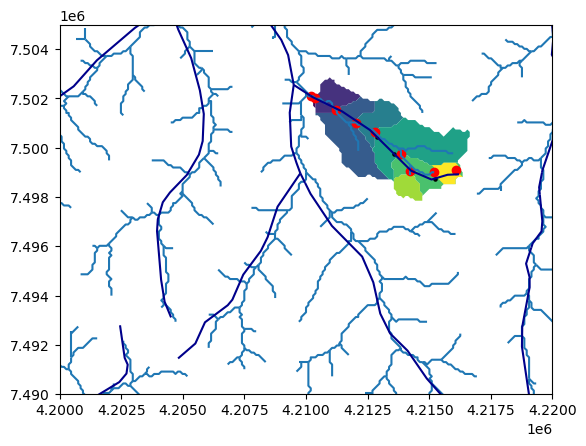

In [318]:
ax = extracted_river_networks[1].plot()
rivers_subset.plot(ax = ax, color = "darkblue")
gpd.GeoDataFrame(geometry = polygons_affine_space_differenced).reset_index().plot(ax = ax, column = "index")
gpd.GeoSeries([cedge.interpolate(1000 * (i + 1)) for i in range(ccuts)]).plot(ax = ax, color = "black", markersize=5)
gpd.GeoSeries(np.apply_along_axis(Point, 1, snapped)).plot(ax = ax, color = "red")
#gpd.GeoSeries().plot(ax = ax, color = "orange")

ax.set_xlim(4.2e6, 4.22e6)
ax.set_ylim(7.49e6, 7.505e6)

In [32]:
#https://stackoverflow.com/a/64649730
import cv2
contours, _ = cv2.findContours(np.array(masks[0]).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [206]:
# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

In [176]:
np.unique(xr.DataArray(acc), return_counts=True)

(array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 6.10587e+05,
        6.10591e+05, 6.10592e+05]),
 array([  3676, 541796, 233681, ...,      1,      1,      1]))

In [ ]:
# Target: Polygons per subsegment/segment/river/estuary to query deforestation data
# Maxmimum length of 1000m at river


In [223]:
rivers_brazil_shapefile.to_crs(4326).iloc[[0]].bounds

,,,minx,miny,maxx,maxy
0,0,0,-51.897534,-22.677836,-51.873718,-22.634084


In [35]:
cedge = rivers_brazil_shapefile.iloc[0].geometry
coffset = 0

In [42]:
ccuts = int((cedge.length + coffset) // 1000)
noffset = (cedge.length + coffset) % 1000
[cedge.interpolate(1000 * (i + 1)) for i in range(ccuts)]

<Axes: >

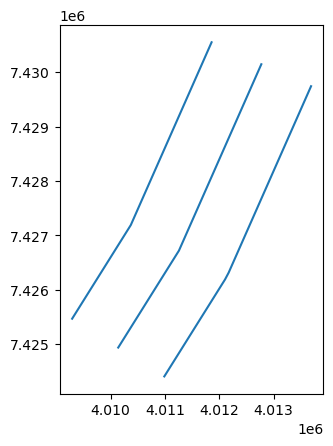

In [63]:
gpd.GeoSeries([cedge.offset_curve(l) for l in [-1000, 0, 1000]]).plot()

<Axes: >

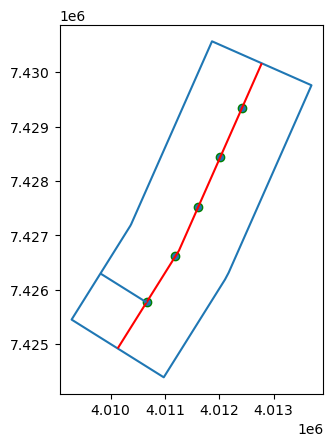

In [54]:
ax = rivers_brazil_shapefile.iloc[[0]].buffer(1000, cap_style="flat").exterior.plot()
rivers_brazil_shapefile.iloc[[0]].plot(ax = ax, edgecolor = "red")
gpd.GeoSeries([cedge.interpolate(1000 * (i + 1)) for i in range(ccuts)]).plot(ax = ax, edgecolor = "green")
shapely.shortest_line(cedge.interpolate(1000), rivers_brazil_shapefile.iloc[[0]].buffer(1000).exterior).plot(ax = ax)

In [ ]:
# TODO: Produce plots

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,10))
rivers_brazil_shapefile.plot(ax = ax, column = "estuary", cmap = "tab20", linewidth = .1)
rivers_brazil_shapefile[rivers_brazil_shapefile.estuary.isna()].plot(ax = ax, color = "black", linewidth = .1)

In [ ]:
nodes_counts = np.unique(subset.points, return_counts = True, axis = 0)

<Axes: >

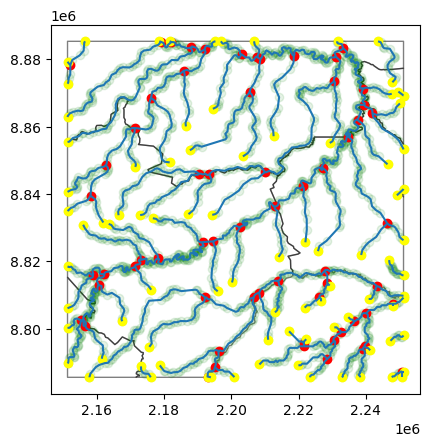

In [ ]:
ax = rivers_subset.plot()
boundaries_subset.plot(ax = ax, edgecolor = "black", color = "None", alpha = .5)
gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] == 1]]).plot(ax = ax, color = "green", alpha = .1)
#gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] == 2]]).plot(ax = ax, color = "purple")
gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] > 2]]).plot(ax = ax, color = "red")
gpd.GeoSeries([shapely.geometry.Point(x) for x in subset.ends]).plot(ax = ax, color = "yellow")

<Axes: >

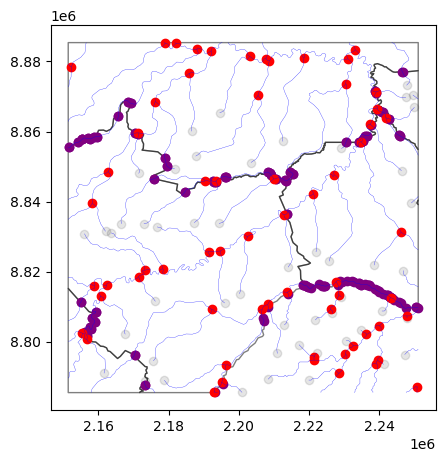

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (5,5))
gpd.clip(rivers_brazil_shapefile, grid_data.geometry.iloc[[i]].total_bounds).plot(ax = ax, linewidth = .2, edgecolor = "blue")
boundaries_subset.plot(ax = ax, edgecolor = "black", color = "None", alpha = .5)
gpd.clip(gpd.GeoSeries(np.apply_along_axis(Point, 1, rivers_brazil.end_nodes)), grid_data.geometry.iloc[[i]].total_bounds).plot(ax = ax, color = "black", alpha = .1)
gpd.clip(gpd.GeoSeries(np.apply_along_axis(Point, 1, rivers_brazil.border_nodes)), grid_data.geometry.iloc[[i]].total_bounds).plot(ax = ax, color = "purple")
gpd.clip(gpd.GeoSeries(np.apply_along_axis(Point, 1, rivers_brazil.network_nodes)), grid_data.geometry.iloc[[i]].total_bounds).plot(ax = ax, color = "red")

In [ ]:
rivers_brazil_shapefile[~rivers_brazil_shapefile.estuary.isna()].plot(column="adm2", lw=.1)

In [151]:
dict_points = defaultdict(list)
# Iterate over pairs of corresponding tuples from both arrays
for point, index in zip(rivers_brazil_shapefile.dropna(subset = "downstream_node_id").downstream_node_id.astype(np.int32), rivers_brazil_shapefile.dropna(subset = "downstream_node_id").index):
    # Append the index to the list corresponding to the point
    dict_points[point].append(index)
# Convert defaultdict to dict if necessary
downstream_lookup = dict(dict_points)

In [105]:
upstream_lookup = {key: value for key, value in zip(rivers_brazil_shapefile.dropna(subset = "upstream_node_id").index, rivers_brazil_shapefile.dropna(subset = "upstream_node_id").upstream_node_id.astype(np.int32))}

In [178]:
end_node_lookup = {x: True for x in rivers_brazil_topology[rivers_brazil_topology.source & ~rivers_brazil_topology.estuary].index}

In [115]:
rivers_brazil_shapefile.query(f"estuary=={query[0]} & river=={query[1]} & segment=={query[2]}")

,,,NORIOCOMP,CORIO,downstream_node_id,upstream_node_id,adm2,estuary,river,segment,subsegment,geometry
42141,0,614,Rio Paranapanema,864_0,157960.0,75413.0,3110.0,228.0,8528.0,72.0,0.0,"LINESTRING (4011743.158 7431655.414, 4011729.0..."


In [201]:
query = [rivers_brazil_shapefile[rivers_brazil_shapefile.adm2 == 3110].groupby(["estuary", "river"], as_index = False).segment.idxmin().segment.iloc[0]]
out = []
while query:
    tmp = upstream_lookup[query.pop()]
    if not end_node_lookup.get(tmp, False):
        tmp = downstream_lookup[tmp]
        out += tmp
        query += tmp

<Axes: >

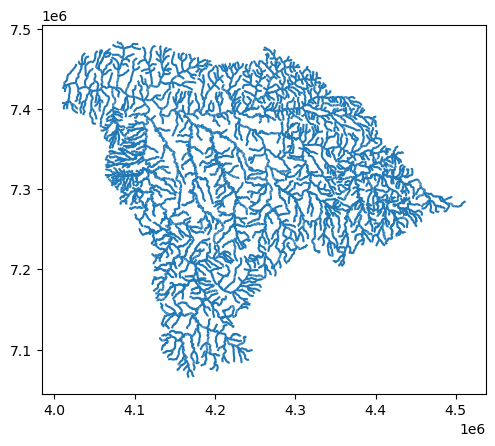

In [203]:
rivers_brazil_shapefile.loc[out].plot()

<Axes: >

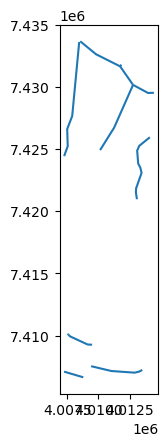

In [81]:
rivers_brazil_shapefile[rivers_brazil_shapefile.adm2 == 3110].plot()

---

# Drainage Model

In [ ]:
# TODO: Formalize these downloads

In [74]:
import urllib
urllib.request.urlretrieve("https://opendata.arcgis.com/api/v3/datasets/4c606c38ee534b84bffe70ca6c8552c6_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1", "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trench.geojson")

('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trench.geojson',
 <http.client.HTTPMessage at 0x152f9ec48880>)

In [75]:
urllib.request.urlretrieve("https://opendata.arcgis.com/api/v3/datasets/2f54775d2229431bad6a41daf3ed04d8_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1", "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_area.geojson")

('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_area.geojson',
 <http.client.HTTPMessage at 0x152f9ecb6220>)

In [76]:
urllib.request.urlretrieve("https://opendata.arcgis.com/api/v3/datasets/5b97dc790ebc4307938d8a5b089c1aab_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1", "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trenches.geojson")


('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trenches.geojson',
 <http.client.HTTPMessage at 0x152f9eca1910>)

In [78]:
test = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trenches.geojson", engine="pyogrio")

In [79]:
test

,OBJECTID,ID,COTRECHO,COCURSODAG,COBACIA,NUCOMPTREC,NUDISTBACT,NUDISTCDAG,NUAREACONT,NUAREAMONT,...,NUORDEMCDA,NUCOMPCDA,NUNIVOTTO,NUNIVOTCDA,NUSTRAHLER,DEDOMINIAL,DSVERSAO,TNACIONAL,SHAPE_Length,geometry
0,1,50160,50160,None,93,1102.003699,NaN,NaN,104747.047340,104747.047340,...,NaN,NaN,2,NaN,NaN,Linha de Costa,BHO bho_2017_v_01_05_5k de 2018-06-20,0,11.479881,"MULTILINESTRING ((-62.15593 -39.38203, -62.155..."
1,2,3303825,3303825,None,35,4.721952,NaN,NaN,2.352449,2.352449,...,NaN,NaN,2,NaN,NaN,Linha de Costa,BHO ilha_mexiana de 2018-02-19,0,0.042475,"MULTILINESTRING ((-49.57455 0.07924, -49.57500..."
2,3,3304042,3304042,None,973,1.170633,NaN,NaN,0.394405,0.394405,...,NaN,NaN,3,NaN,NaN,Linha de Costa,BHO ilha_caviana_de_fora de 2018-02-20,1,0.010528,"MULTILINESTRING ((-49.57113 0.28340, -49.57414..."
3,4,3304046,3304046,None,1115,4.465403,NaN,NaN,2.767990,2.767990,...,NaN,NaN,4,NaN,NaN,Linha de Costa,BHO ilha_caviana_de_fora de 2018-02-20,1,0.040162,"MULTILINESTRING ((-49.62472 0.36304, -49.61984..."
4,5,3304044,3304044,None,11113,0.727614,NaN,NaN,0.225937,0.225937,...,NaN,NaN,5,NaN,NaN,Linha de Costa,BHO ilha_caviana_de_fora de 2018-02-20,1,0.006546,"MULTILINESTRING ((-49.56746 0.36666, -49.56650..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464062,464063,122246,122246,None,77997311,65.893703,NaN,NaN,238.728329,238.728329,...,NaN,NaN,8,NaN,NaN,Linha de Costa,BHO bho_2017_v_01_05_5k de 2018-06-20,1,0.649194,"MULTILINESTRING ((-51.54404 -31.76413, -51.544..."
464063,464064,137556,137556,774176,774176913,3.082342,455.331840,49.590287,6.159381,425.759261,...,2.0,88.254017,9,6.0,3.0,Estadual,BHO bho_2017_v_01_05_5k de 2018-06-20,1,0.027734,"MULTILINESTRING ((-41.46475 -16.93666, -41.464..."
464064,464065,430340,430340,6411324,64113241,0.370044,811.367615,0.000000,0.197901,97.119867,...,4.0,19.156837,8,7.0,2.0,Estadual,BHO bho_2017_v_01_05_5k de 2018-06-20,1,0.003339,"MULTILINESTRING ((-47.93699 -5.35312, -47.9368..."
464065,464066,82481,82481,4816,4816513,1.402432,1734.370391,161.123838,8.987300,8036.068845,...,3.0,458.060851,7,4.0,4.0,Estadual,BHO bho_2017_v_01_05_5k de 2018-06-20,1,0.012573,"MULTILINESTRING ((-62.11536 -2.08898, -62.1080..."


In [ ]:
# TODO: Create matching between basins and river -> cut subpolygons with river segments

---

# Water Quality Measurements

In [ ]:
# download template:
"https://www.snirh.gov.br/hidroweb/rest/api/documento/download/files?tipodocumento=csv&codigoestacao=10010000&forcenewfiles=N"

In [ ]:
# TODO: Get list of stations and scrape data

---

# Other

In [ ]:
import ctypes
import numpy as np

j = 23

# Load the shared library
lib = ctypes.CDLL('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/analysis/deforestation_extract.so')

# Define the argument and return types for the function
lib.calculatePolygons.argtypes = [
    ctypes.POINTER(ctypes.c_double), 
    ctypes.POINTER(ctypes.c_double), 
    ctypes.c_int, 
    ctypes.c_double, 
    ctypes.POINTER(ctypes.POINTER(ctypes.c_double)), 
    ctypes.POINTER(ctypes.POINTER(ctypes.c_double))
]
lib.calculatePolygons.restype = None

# Define the input data
X, Y = np.array(rivers_subset.geometry.iloc[j].coords.xy, dtype = np.double)
distance = 1000
N = len(X)

# Call the C++ function
polygonsX_ptr = ctypes.POINTER(ctypes.c_double)()
polygonsY_ptr = ctypes.POINTER(ctypes.c_double)()
lib.calculatePolygons(
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    N, 
    distance, 
    ctypes.byref(polygonsX_ptr), 
    ctypes.byref(polygonsY_ptr)
)

# Convert the output to numpy arrays
polygonsX = np.ctypeslib.as_array(polygonsX_ptr, shape=(N - 3, 6))
polygonsY = np.ctypeslib.as_array(polygonsY_ptr, shape=(N - 3, 6))

test = np.array([shapely.geometry.Polygon([(polygonsX[i][j], polygonsY[i][j]) for j in range(6)]) for i in range(N - 3)])

# Free the allocated memory
lib.free(polygonsX_ptr)
lib.free(polygonsY_ptr)

0

<Axes: >

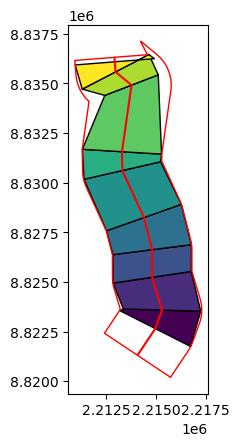

In [ ]:
test_series = gpd.GeoSeries(test).reset_index()
ax = rivers_subset.iloc[[j]].plot(color = "red")
test_series.plot(ax = ax, edgecolor = "black", column = "index")
rivers_subset.iloc[[j]].buffer(2 * 1000, cap_style = "flat").plot(edgecolor = "red", color = "none", ax = ax)
